Welcome to Week 2 of our seminar on "Applied Quantitative Methods in Finance." This week, we are diving into the world of linear regression analysis, a fundamental statistical technique used extensively in financial research for exploring and modeling relationships between variables.

Our focus will be on Cross-Sectional Linear Regression, which involves examining a dataset at a single point in time to identify the relationships between independent variables and a dependent variable. This method is particularly useful in finance for predicting stock prices, assessing economic impacts on asset returns, and more.

We'll start with Scatterplots, an essential graphical tool for visualizing the relationship between two quantitative variables. Scatterplots help us intuitively grasp how variables interact, providing a visual foundation for the theoretical work in regression.

Next, we'll delve into Assessing Regression Assumptions. Linear regression comes with several key assumptions, including linearity, independence, homoscedasticity, and normal distribution of residuals. We will learn how to check these assumptions through diagnostic plots and statistical tests to ensure that our regression model provides valid and reliable results.

Throughout the week, we will use Python to implement these techniques, allowing you to gain hands-on experience with real data and practical scenarios. This combination of theory and application will equip you with the tools to perform robust quantitative analyses in your future finance projects.

# Package Imports

As we dive deeper into more complex analyses, we increase our use of Python community packages.  The two more popular packages for regression type analysis are statsmodels and scipy.   Both of these are being maintained by a community of academic researchers, and have excellent documentation.  

The statsmodels site on linear regression is a good reference point, should you ever have any questions about how to apply the package to new projects:  https://www.statsmodels.org/stable/regression.html

In [5]:
# Basic imports of our data handling libraries
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns
import numpy as np

In [6]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.compat import lzip
import scipy.stats as stats

# seaborn contains some useful pre-packaged plots for data reviews and regression analysis
import seaborn as sns
import matplotlib.pyplot as plt
 # configure plt so that it displays well within Jupyter notebooks
%matplotlib inline 

In [7]:
# we will use plotnine for our custom plots
from plotnine import ggplot, aes, geom_histogram, geom_line, geom_point, geom_hline, geom_density, geom_segment, \
                        facet_wrap, labs, theme, ggtitle, theme_minimal, scale_x_continuous, scale_y_continuous

# R\&D Intensity and Firm Value

This week we are designing a study on R&D Intensity and Firm Value.

Research Question: Does R&D intensity influence firm value, and how do different governance mechanisms (as a proxy for agency costs) moderate this relationship?

These are the variables we will use for this study:
- Dependent Variable: Firm Value (measured as Tobin's Q)
- Independent Variable: R&D Intensity (R&D expenses divided by total sales)
- Control Variables: leverage (debt to equity ratio), profitability (return on assets)
- Moderating Variables: Governance mechanisms such as CEO duality (where the CEO is also the chairperson of the board) and board size

Hypotheses:
- H1: Higher R&D intensity is positively associated with higher firm value.
- H2: CEO duality weakens the positive relationship between R&D intensity and firm value (indicating higher agency costs).
- H3: Larger board size strengthens the positive relationship between R&D intensity and firm value (suggesting better oversight and reduced agency costs).

We will carry out this study cross-sectionally, therefore we are purely intersted in correlation strength between the variables and not causation.  

## Data Collection

The variables for our project will come from two sources:  
1. Compustat Annual Industrial/Full Coverage Files: These files contain comprehensive financial data including sales, total assets, and R&D expenses.
2. Executive Compensation (Execucomp) Database: For data on CEO duality and board size.

For our cross-sectional study, we will need a table that contains one observation per firm with each of the pertinent data fields.

In [8]:
# imports to enable WRDS access and SQL calls
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [9]:
# load password/username and connect to WRDS
load_dotenv()
connection_string = (
  "postgresql+psycopg2://"
 f"{os.getenv('WRDS_USER')}:{os.getenv('WRDS_PASSWORD')}"
  "@wrds-pgdata.wharton.upenn.edu:9737/wrds"
)
wrds_engine = create_engine(connection_string, pool_pre_ping=True)

### Compustat

To select firms, we are going to query the WRDS DB for all tickers in the SP500 with end date post the beginning of 2022.  Importantly, this table always maintains an end date, even if the participation of the firm in the index has not ended. 

This can be freely refined of course, and you might want to set different inclusion criteria to get a larger data set. 


In [10]:
cutoff_date = '2022-01-01'

In [11]:
# or query the WRDS DB for all tickers in the SP500 with end date post study start date
ticker_query = (
    "SELECT DISTINCT stn.ticker "
    "FROM  	crsp.dsp500list as dsp500list "
    "LEFT JOIN crsp.stocknames as stn "
    "ON dsp500list.permno = stn.permno "
   f"WHERE dsp500list.ending > '{cutoff_date}' "
)
tickers_ = pd.read_sql_query(
    sql=ticker_query,
    con=wrds_engine,
)
tickers_ = tickers_.dropna()

Next, to be able to select by ticker, we need to put them into the right format that can be embedded in SQL.

In [20]:
# truncate number of tickers when in development to speed up database calls
selected_tickers_ = tickers_#[0:100]
# format tickers so they can be used in a query
formatted_tickers = "'" + "', '".join(list(selected_tickers_.ticker)) + "'"

len(selected_tickers_)

797

In [13]:
formatted_tickers

"'ABC', 'MGMG', 'RSG', 'COG', 'MOT', 'INVH', 'IFF', 'V', 'CCI', 'FBHS', 'TRV', 'AVGO', 'PFE', 'ERI', 'DBNK', 'BRO', 'ROP', 'TER', 'VRSN', 'AA', 'AAP', 'DTE', 'NUE', 'CE', 'EA', 'PNCF', 'UW', 'NU', 'FI', 'MHK', 'TXN', 'DXC', 'ZION', 'EGAS', 'ES', 'STE', 'PBCT', 'DMG', 'ANTM', 'MWD', 'MSU', 'MPC', 'UNH', 'MMM', 'MDTR', 'DD', 'NOW', 'AKAM', 'TFX', 'NVR', 'FIC', 'ACE', 'HOLX', 'RCR', 'LTR', 'AES', 'ELV', 'OMCM', 'ACAD', 'PLD', 'GRMN', 'AHAA', 'CTSH', 'MMC', 'PAYC', 'D', 'SWKS', 'XLNX', 'FTV', 'INFO', 'MWV', 'ACL', 'AOC', 'EMN', 'HON', 'BAM', 'ABT', 'PG', 'CDNC', 'ALL', 'DBKT', 'SPG', 'QRVO', 'STRY', 'WRK', 'LKQ', 'BIO', 'STT', 'PROG', 'MLM', 'SBAC', 'GEN', 'AFL', 'ONNN', 'GLW', 'KLAC', 'TRGP', 'FICO', 'MNST', 'FLT', 'DISCK', 'ENX', 'CBG', 'ADM', 'RESM', 'PPL', 'NFLX', 'EVRG', 'MKC', 'WFC', 'HCP', 'HST', 'FEMP', 'UEP', 'PPG', 'REI', 'ROK', 'WSH', 'BXP', 'WMT', 'PXD', 'BHI', 'RF', 'SYMC', 'ABBV', 'SNAP', 'WRB', 'FSLR', 'MSFT', 'BCP', 'RL', 'MAS', 'RGBK', 'IRM', 'AUD', 'XRAY', 'TTWO', 'ODFL',

We are going to select the following fundamentals from Compustat for each firm.  We just read data from the last annual filing. 

- csho: Common Shares Outstanding
- prcc_f: Price Close - Annual - Fiscal
- dltt: Long-Term Debt - Total
- dlc: Debt in Current Liabilities - Total
- xrd: Research and Development Expense
- sale: Sales/Turnover (Net)
- ceq: Common/Ordinary Equity - Total
- ni: Net Income (Loss) 
- at: Assets - Total
- ppent: Property, Plant and Equipment - Total  

In [14]:
compustat_data_raw = pd.read_sql_query(
    sql=f" \
    SELECT tic, gvkey , datadate ,  \
           csho, prcc_f, dltt, dlc, at, xrd, sale, ceq, ni, ppent \
    FROM  	comp.funda as funda  \
    WHERE funda.tic IN ({formatted_tickers}) \
    AND funda.datafmt = 'STD' \
    AND funda.indfmt = 'INDL' \
    AND funda.popsrc = 'D' \
    AND consol = 'C'  \
    AND funda.datadate = ( \
        SELECT MAX(funda2.datadate) \
        FROM comp.funda as funda2 \
        WHERE funda2.gvkey = funda.gvkey \
        AND funda2.datadate > '{cutoff_date}' \
    ) \
    ",
    con=wrds_engine,
)

In [15]:
compustat_data_raw

,tic,gvkey,datadate,csho,prcc_f,dltt,dlc,at,xrd,sale,ceq,ni,ppent
0,A,126554,2023-10-31,292.123,103.37,2853.000,46.000,10763.000,481.0,6833.000,5845.000,1240.000,1424.000
1,AA,027638,2023-12-31,178.472,34.00,1836.000,166.000,14155.000,39.0,10551.000,4251.000,-651.000,6785.000
2,AAL,001045,2023-12-31,654.273,13.74,35722.000,4941.000,63058.000,NaN,52788.000,-5202.000,822.000,38703.000
3,AAP,145977,2023-12-31,59.512,61.03,4002.127,445.061,12276.326,0.0,11287.607,2519.728,29.735,4227.322
4,AAPL,001690,2023-09-30,15550.061,171.21,106548.000,17382.000,352583.000,29915.0,383285.000,62146.000,96995.000,54376.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,YUM,065417,2023-12-31,281.000,130.66,11899.000,132.000,6231.000,NaN,7076.000,-7858.000,1597.000,1961.000
547,ZBH,144559,2023-12-31,205.600,121.70,5042.300,952.900,21496.900,458.7,7394.200,12480.500,1024.000,2264.200
548,ZBRA,024405,2023-12-31,51.379,273.33,2199.000,215.000,7306.000,519.0,4584.000,3036.000,296.000,478.000
549,ZION,011687,2023-12-31,148.153,43.87,740.000,4379.000,87203.000,NaN,4624.000,5251.000,680.000,1572.000


### BoardEx

Compustat gives us data on firm fundamentals, but it doesn't give us data on the governance structure.  We have to collect this data from another place.   Data on board composition is available in both BoardEx and Execucomp, and BoardEx goes a bit deeper into detail on the board members, which is why we use this data source. 

The tricky thing though is that BoardEx uses a different primary key for firms, it uses something called companyid (or baordid, which is identical but confusingly carries a different name).

First we create a cross reference table that maps stock tickers to BoardEx identifiers.  Note that this query might take a few minutes to complete. 

In [16]:
# assemble the SQL code to generate the cross reference
boardex_ticker_xref = pd.read_sql_query(
  sql=f"SELECT DISTINCT stn.ticker, xlink.companyid \
        FROM crsp.stocknames as stn   \
        LEFT JOIN wrdsapps.bdxcrspcomplink as xlink \
        ON stn.permco = xlink.permco \
        WHERE stn.ticker IN ({formatted_tickers}) \
        AND xlink.companyid IS NOT NULL \
        AND stn.nameenddt = ( \
          SELECT MAX(stn2.nameenddt) \
          FROM crsp.stocknames AS stn2 \
          WHERE stn2.ticker = stn.ticker \
      )",
  dtype={"companyid": int},
  con=wrds_engine,
)

In [17]:
# put the companyids into a format that we can use for the SQL query
formatted_companyids = "'" + "', '".join(boardex_ticker_xref.companyid.values.astype(str)) + "'"

Our goals is to find information on the number of board members, and whether the CEO is also Chairman.  We download a list of all board members of firms in our list, and we will subsequently review this data to generate our variables.  BoardEx changes identifiers occasionally and we only want the latest one, therefore we select by cutoff date as before.  

Note that we also download some additional data points, such as gender of the board members and their network size, which are unused in this case, but might be useful for other research projects. 

This query might take a few minutes to complete. 

In [18]:
boardex_raw = pd.read_sql_query(
  sql=f"SELECT summary.boardid, summary.ned, summary.gender, summary.networksize, summary.rolename, summary.directorname,  \
              summary.annualreportdate \
        FROM boardex.na_wrds_org_summary as summary  \
        WHERE boardid IN ({formatted_companyids}) \
        AND summary.annualreportdate = ( \
          SELECT MAX(summary2.annualreportdate) \
          FROM boardex.na_wrds_org_summary as summary2 \
          WHERE summary2.boardid = summary.boardid \
          AND summary2.annualreportdate > '{cutoff_date}' \
      ) \
        ",
  dtype={"boardid": int},
  con=wrds_engine,
)

In [21]:
boardex_raw

,boardid,ned,gender,networksize,rolename,directorname,annualreportdate
0,324,Yes,M,711.0,Independent Director,Emerson Brumback,2023-12-01
1,324,Yes,M,1251.0,Independent Director,Mike McCallister,2023-12-01
2,324,Yes,F,1121.0,Independent Director,Marsha Williams,2023-12-01
3,324,Yes,M,1653.0,Independent Director,Thomas Harvey,2023-12-01
4,324,Yes,M,1077.0,Independent Director,Mitch Feiger,2023-12-01
...,...,...,...,...,...,...,...
9401,3689160,Yes,M,1268.0,Director - SD,Bill King IV,2023-09-01
9402,3689160,Yes,F,1463.0,Independent Director,Cindy Wallis-Lage,2023-09-01
9403,3689160,Yes,F,756.0,Independent Director,Françoise Colpron,2023-09-01
9404,3689160,Yes,M,1298.0,Independent Director,Shyam Kambeyanda,2023-09-01


## Initial Data Cleansing, Variable Calculation and Merging the Data Set

First we carry out some initial data cleansing, such as removal of NA values. We also calculate our variables of interest. Finally, we set our index to the ticker (i.e. firm), because that is the level of observation. 

In [22]:
compustat_data = (compustat_data_raw
    .fillna({
        'xrd': 0,  # Assuming if R&D is NaN, it means no R&D expenses
        'sale': 1,  # Avoid division by zero
        'dltt': 0,
        'dlc': 0,
        'ceq': 1  # Avoid division by zero
        })
    .assign(
        tobins_q = lambda x: ( ( x['csho'] * x['prcc_f'] + x['dltt'] + x['dlc']) / x['at'] ) ,
        rd_intensity = lambda x:  x['xrd'] / x['sale'],
        leverage = lambda x: (x['dltt'] + x['dlc']) / x['ceq'],
        roa = lambda x: x['ni'] / x['at'],
    )
    .get(['tic', 'tobins_q', 'rd_intensity', 'leverage', 'roa', 'at'])
    .dropna()
    .set_index('tic')
)

In [23]:
compustat_data

,tobins_q,rd_intensity,leverage,roa,at
tic,,,,,
A,3.074956,0.070394,0.495979,0.115210,10763.000
AA,0.570120,0.003696,0.470948,-0.045991,14155.000
AAL,0.787413,0.000000,-7.816801,0.013036,63058.000
AAP,0.658113,0.000000,1.764948,0.002422,12276.326
AAPL,7.902411,0.078049,1.994175,0.275098,352583.000
...,...,...,...,...,...
YUM,7.823216,0.000000,-1.531051,0.256299,6231.000
ZBH,1.442846,0.062035,0.480365,0.047635,21496.900
ZBRA,2.252590,0.113220,0.795125,0.040515,7306.000


We do the same for BoardEx Data.  Here we link in the ticker using our cross-reference table.  Then we summarize the data to calculate our variables of interest. 

In [24]:
boardex_data = (boardex_raw
    .merge(boardex_ticker_xref, left_on='boardid', right_on='companyid') # bring in ticker
    .drop(columns=['companyid', 'boardid'])
    .drop_duplicates()
    .groupby('ticker')
    .agg(
        board_size=pd.NamedAgg(column='ticker', aggfunc='size'),  # Count total rows per ticker
        ceo_duality=pd.NamedAgg(column='rolename', aggfunc=lambda x: 'Chairman/CEO' in x.values)  # Check for 'Chairman/CEO' in roles
    )   
)

Finally we combine the two datasets (both have ticker as the index, so we can do an easy join operation).

In [25]:
combined_dataset = compustat_data.join(boardex_data).dropna()

In [26]:
combined_dataset

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
A,3.074956,0.070394,0.495979,0.115210,10763.000,15.0,False
AA,0.570120,0.003696,0.470948,-0.045991,14155.000,10.0,False
AAL,0.787413,0.000000,-7.816801,0.013036,63058.000,19.0,False
AAP,0.658113,0.000000,1.764948,0.002422,12276.326,14.0,False
AAPL,7.902411,0.078049,1.994175,0.275098,352583.000,13.0,False
...,...,...,...,...,...,...,...
YUM,7.823216,0.000000,-1.531051,0.256299,6231.000,14.0,False
ZBH,1.442846,0.062035,0.480365,0.047635,21496.900,10.0,False
ZBRA,2.252590,0.113220,0.795125,0.040515,7306.000,13.0,False


## Data Review and Adjustments

Before diving into the regression analysis, we review the dataset to ensure it aligns with distributional and data cleanliness expectations. 

For ease of reproducibility, we define df_ and df_numeric as shorthand for the data set. 

In [27]:
df_ = combined_dataset
df_numeric = combined_dataset.drop(columns = ["ceo_duality"])

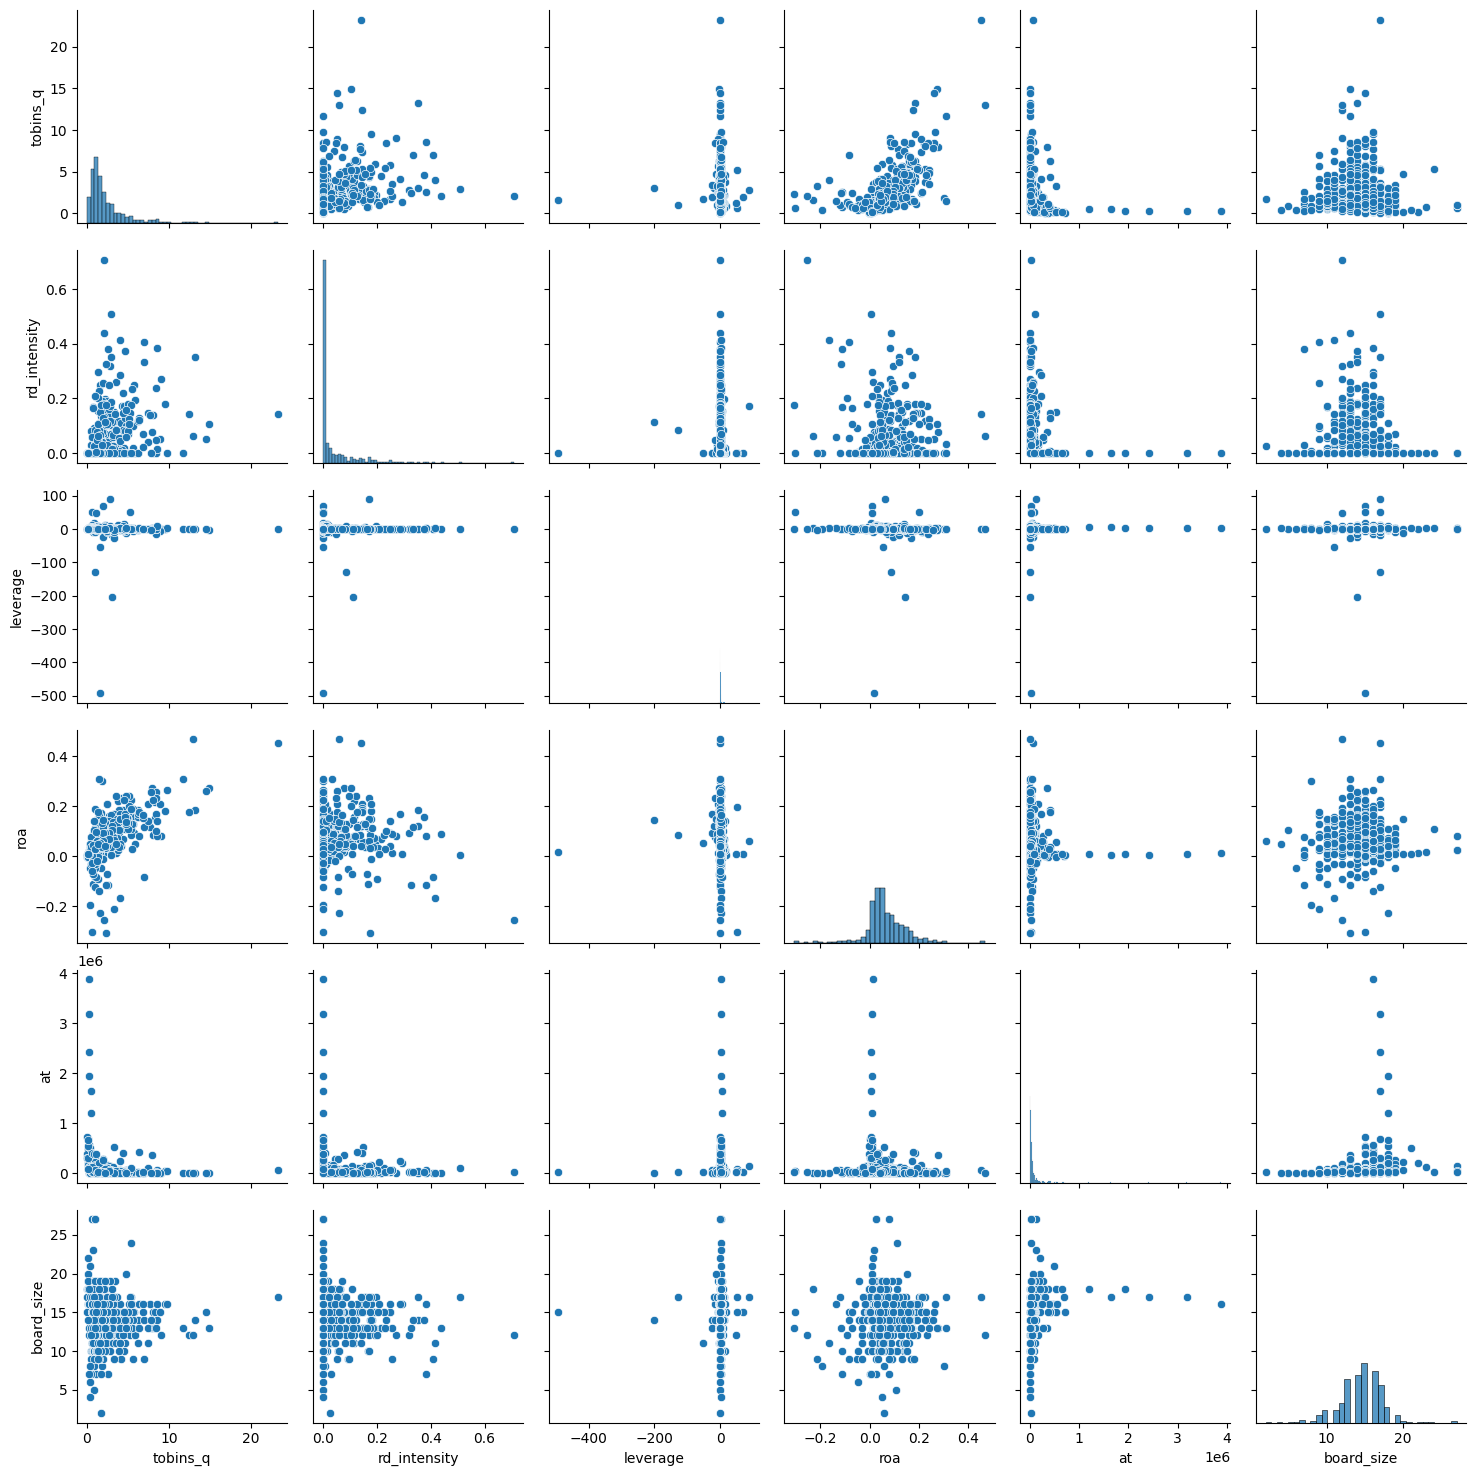

In [28]:
sns.pairplot(df_numeric)

We define a helper function that shows us a consolidated table of the descriptive stats we are most interested in, including skew and kurtosis, which don't come in the standard descriptives tables.

In [29]:
def enhanced_descriptives (df_numeric):
    return pd.DataFrame({'variable':df_numeric.columns,
              'min':stats.describe(df_numeric)[1][0],
              'max':stats.describe(df_numeric)[1][1],
              'mean':stats.describe(df_numeric)[2],
              'std':np.sqrt(stats.describe(df_numeric)[3]),
              'median':df_numeric.median(axis=0),
              'skew':stats.skew(df_numeric, axis=0),
              'skew p-val':stats.skewtest(df_numeric)[1],
              'kurtosis':stats.kurtosis(df_numeric, axis=0),
              'normality test p-val': stats.normaltest(df_numeric, axis=0)[1] }).round(3)

Reviewing skewness and kurtosis gives us an indication of how non-normal the data is distributed:

- Skewness
  - Skewness = 0: normally distributed
  - Skewness > 0: more weight in the left tail of the distribution
  - Skewness < 0: more weight in the right tail of the distribution

- Kurtosis
  - Kurtosis for normal distribution is equal to 3
  - Kurtosis < 3: playkurtic
  - Kurtosis > 3: leptokurtic (tends to produce more outliers than the normal distribution)
 
We further use a chi-squared statistic normality test, and collect associated p-value. This test has the null hypothesis that the data came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen if the data was normally distributed.  



In [30]:
enhanced_descriptives(df_numeric)

,variable,min,max,mean,std,median,skew,skew p-val,kurtosis,normality test p-val
tobins_q,tobins_q,0.029,23.233,2.343,2.362,1.577,3.131,0.000,15.881,0.0
rd_intensity,rd_intensity,0.000,0.708,0.042,0.084,0.000,3.127,0.000,12.910,0.0
leverage,leverage,-492.065,88.844,-0.180,24.716,0.758,-15.814,0.000,299.931,0.0
roa,roa,-0.306,0.467,0.066,0.079,0.055,0.127,0.225,4.784,0.0
at,at,180.488,3875393.000,83364.795,279068.064,24672.076,9.411,0.000,104.040,0.0
board_size,board_size,2.000,27.000,14.511,2.804,15.000,-0.106,0.312,3.061,0.0


We also use the pairplot function from the seaborn package to create an overview of the bivariate relationships and individual variable distributions. 

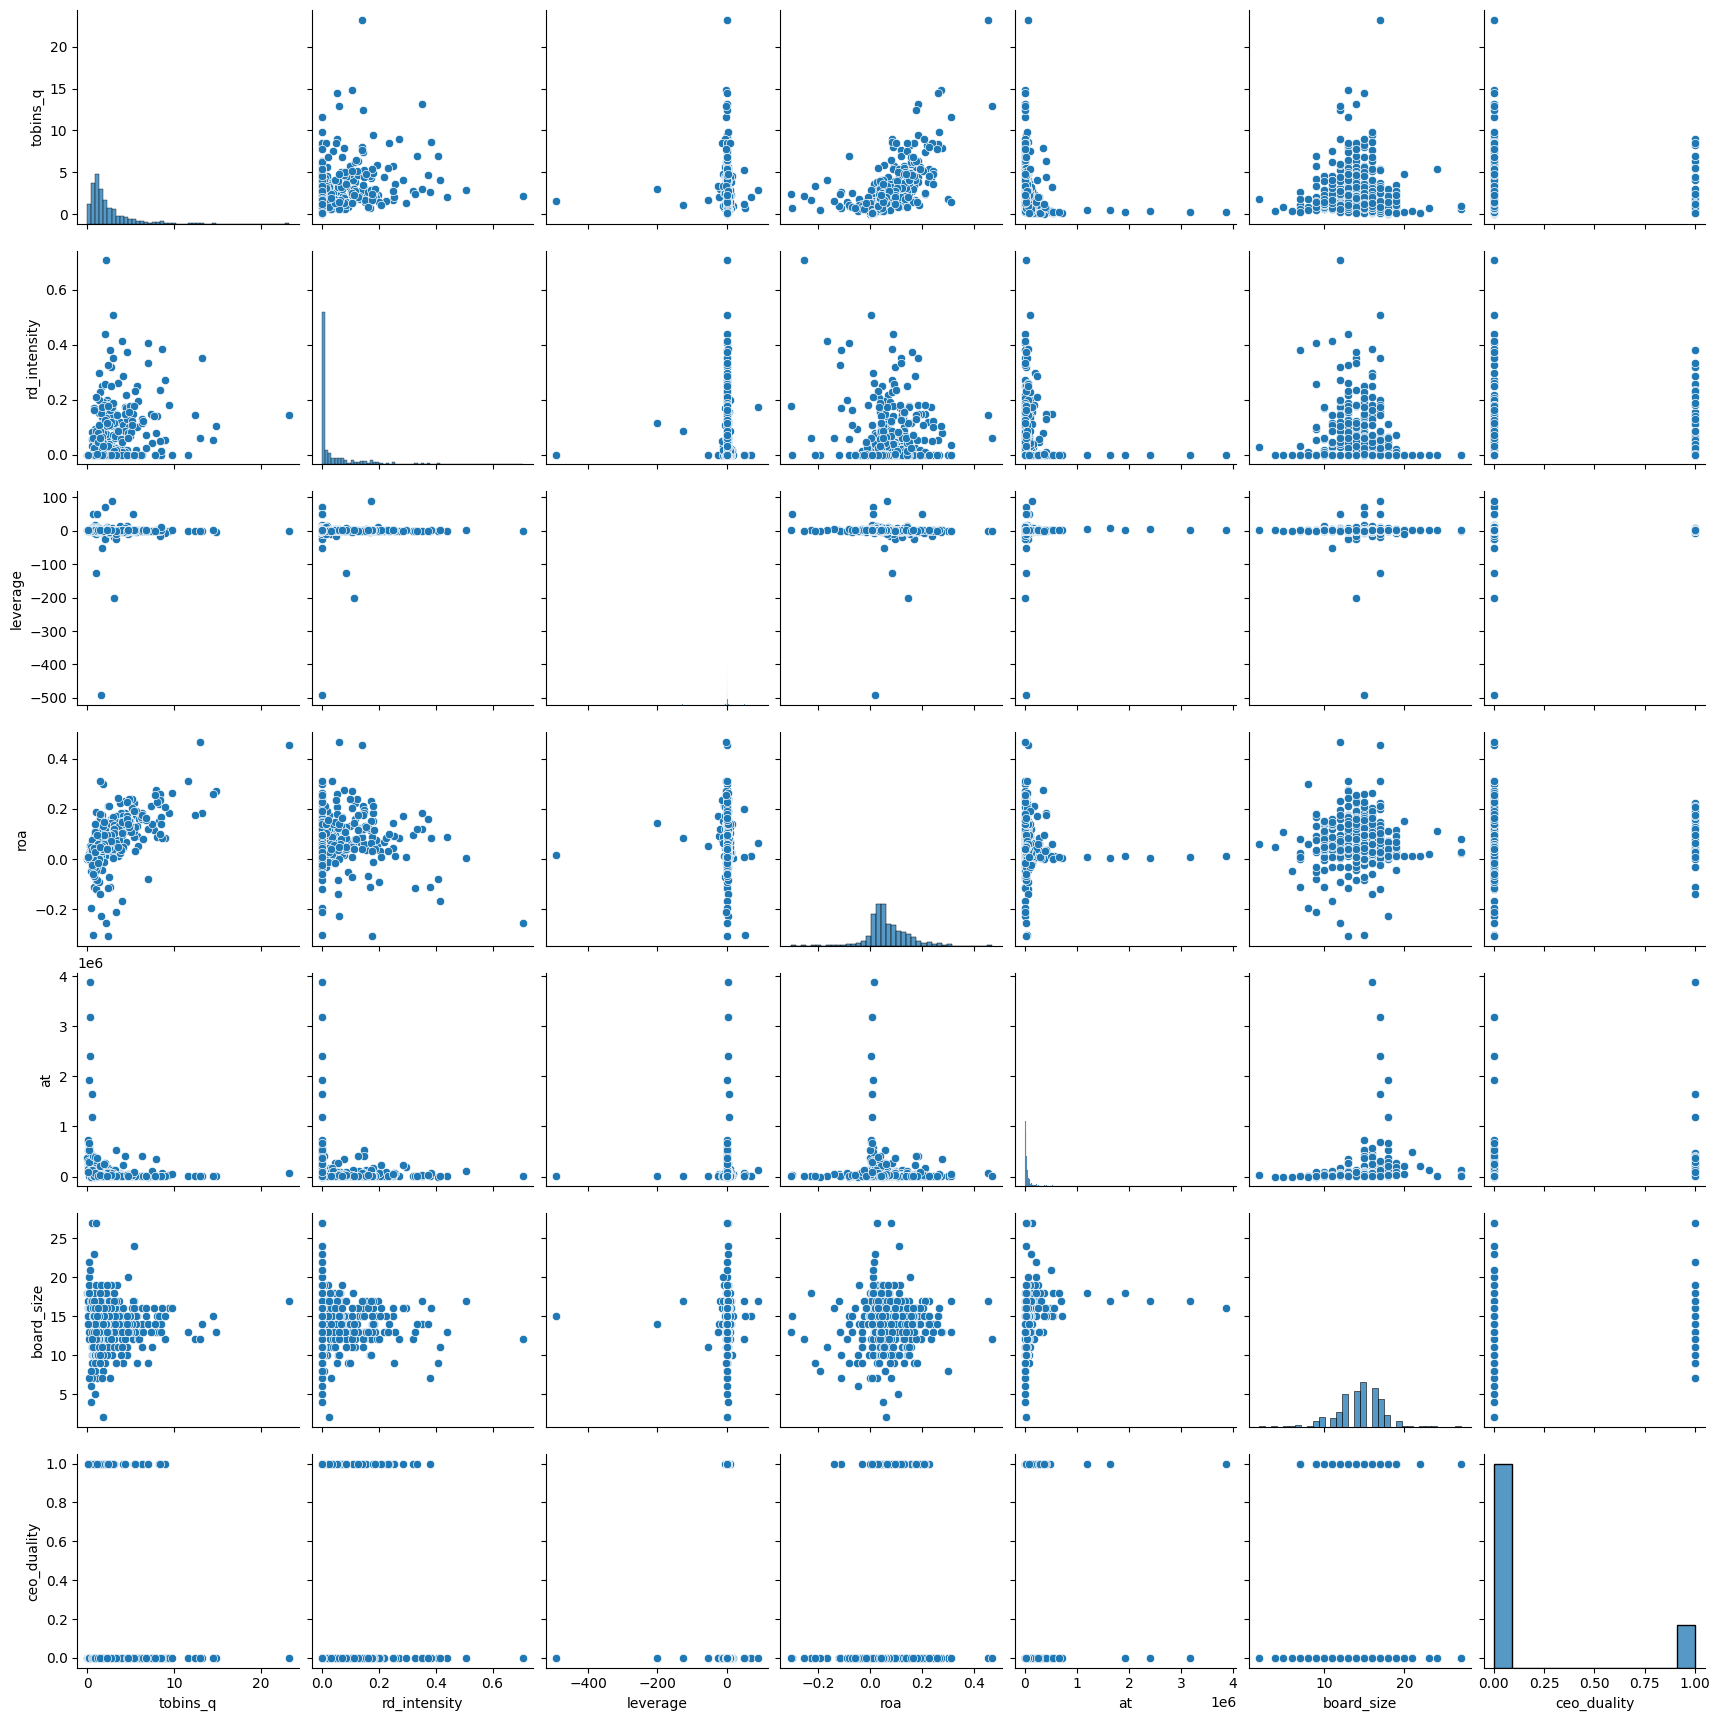

In [31]:
sns.pairplot(df_)

We see that most of the variables do not seem to be normally distributed.    The bivariate relationships also look heavily skewed.  We will need to dive deeper into each variable to troubleshoot.

### Individual Variable Review and Adjustments

We take a copy of our data frame to adjust the variables as we go. 

In [32]:
adjusted_dataset = combined_dataset.copy()

In [33]:
adjusted_dataset

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
A,3.074956,0.070394,0.495979,0.115210,10763.000,15.0,False
AA,0.570120,0.003696,0.470948,-0.045991,14155.000,10.0,False
AAL,0.787413,0.000000,-7.816801,0.013036,63058.000,19.0,False
AAP,0.658113,0.000000,1.764948,0.002422,12276.326,14.0,False
AAPL,7.902411,0.078049,1.994175,0.275098,352583.000,13.0,False
...,...,...,...,...,...,...,...
YUM,7.823216,0.000000,-1.531051,0.256299,6231.000,14.0,False
ZBH,1.442846,0.062035,0.480365,0.047635,21496.900,10.0,False
ZBRA,2.252590,0.113220,0.795125,0.040515,7306.000,13.0,False


Tobin's Q is heavily long tailed, let's make a log adjustments. 

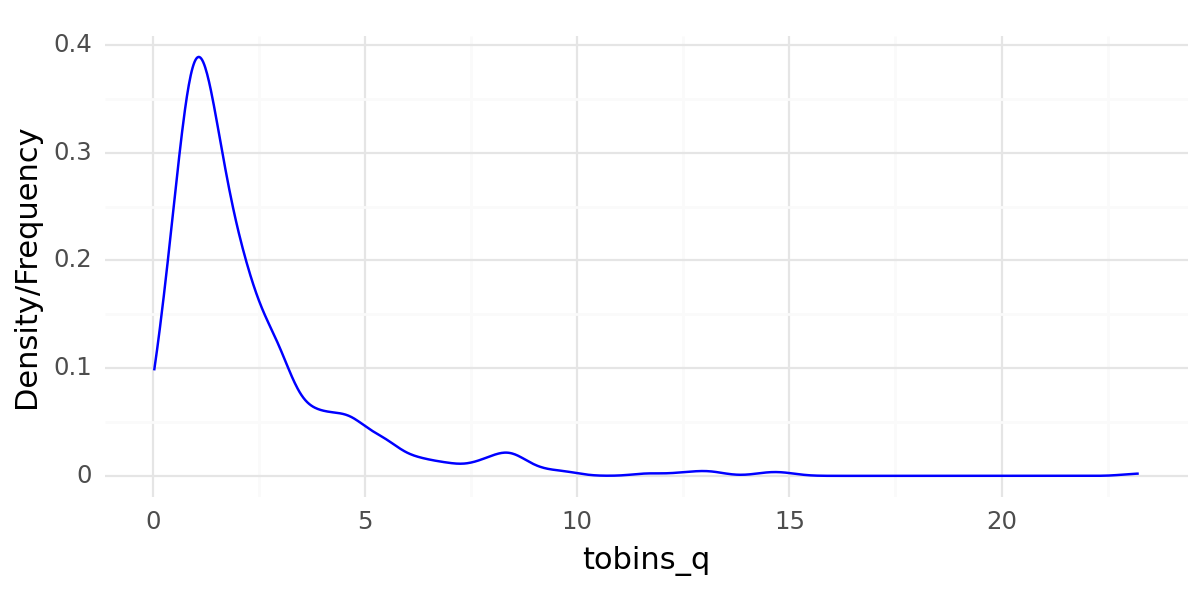

<Figure Size: (600 x 300)>

In [34]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='tobins_q', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [35]:
# log adjustment
adjusted_dataset = (adjusted_dataset
 .assign(
     tobins_q = lambda x:  np.log(x['tobins_q'])
 )
)

Now it looks a lot more normally distributed.

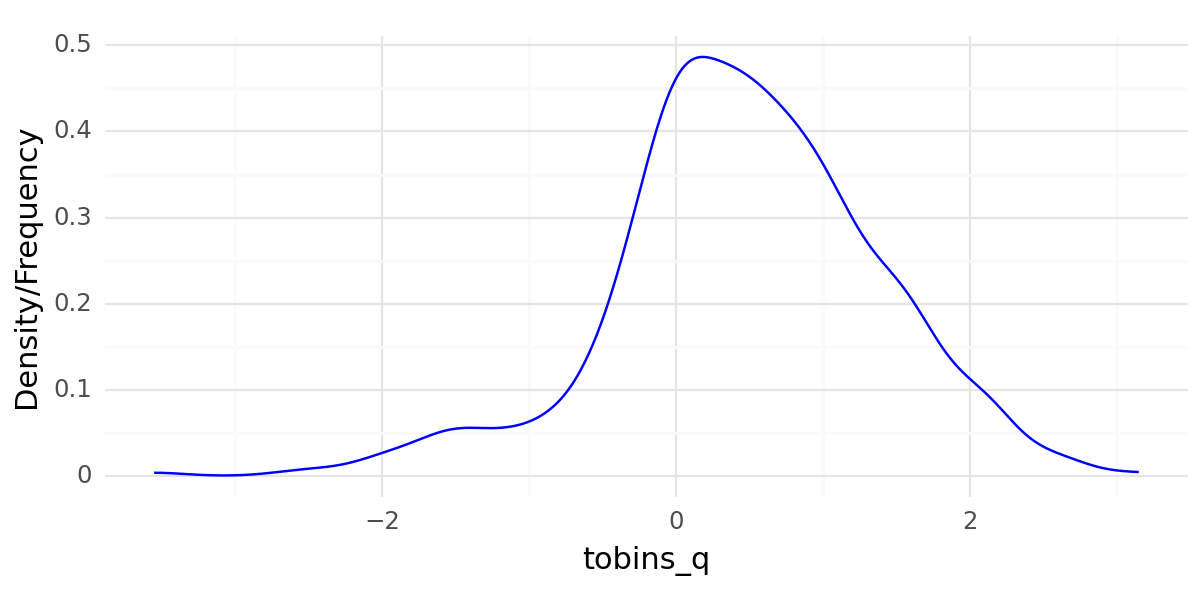

<Figure Size: (600 x 300)>

In [36]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='tobins_q', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Graphing R\&D intensity highlights an issue - many firms in our dataset hav no R\&D intensity measurement!  At this point, we need to make a decision.  We will not be able to find meaningful results if we include all the firms without R\&D investment in our analysis.  We could go back to our data source and double check our variable calculation.  Here we take a simple approach and remove all the firms that have zero R\&D intensity. 

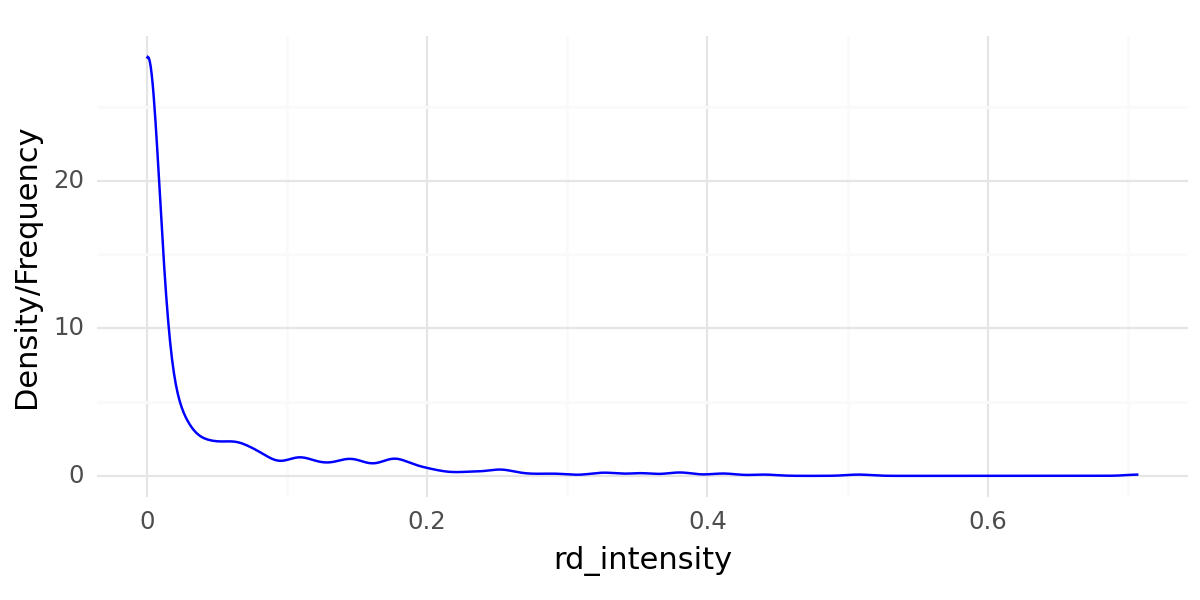

<Figure Size: (600 x 300)>

In [37]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='rd_intensity', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [38]:
# only include firms with > zero R&D intensity
adjusted_dataset = adjusted_dataset[adjusted_dataset['rd_intensity'] > 0]

# we then log adjust to make the distribution more normal
adjusted_dataset = (adjusted_dataset
 .assign(
     rd_intensity = lambda x:  np.log(x['rd_intensity'])
 )
)

In [39]:
adjusted_dataset

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
A,1.123291,-2.653652,0.495979,0.115210,10763.000,15.0,False
AA,-0.561908,-5.600414,0.470948,-0.045991,14155.000,10.0,False
AAPL,2.067168,-2.550419,1.994175,0.275098,352583.000,13.0,False
ABBV,0.907871,-1.860334,5.819112,0.036100,134711.000,17.0,True
ABMD,2.199565,-1.306410,0.006324,0.081574,1673.393,12.0,False
...,...,...,...,...,...,...,...
XRAY,0.271946,-3.070325,0.698148,-0.017910,7370.000,16.0,False
XYL,0.633048,-3.457621,0.268149,0.037798,16112.000,14.0,False
ZBH,0.366618,-2.780055,0.480365,0.047635,21496.900,10.0,False


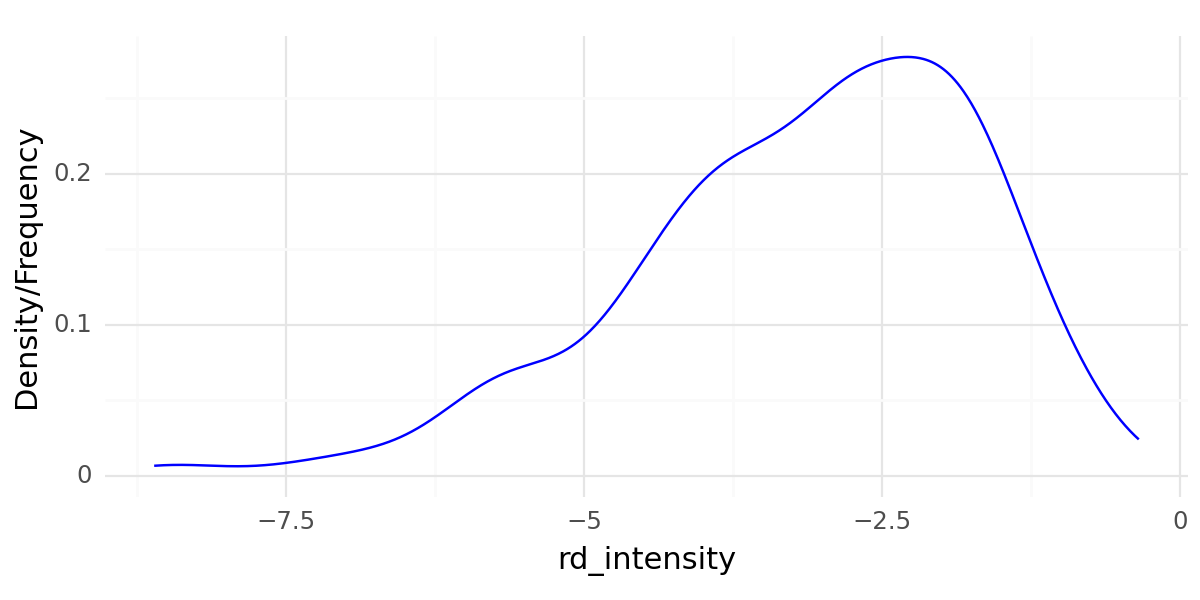

<Figure Size: (600 x 300)>

In [40]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='rd_intensity', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Leverage shows a distribution with a narrow peak and some really extreme outliers.   Since there are very outliers, we remove those firms from our sample. 

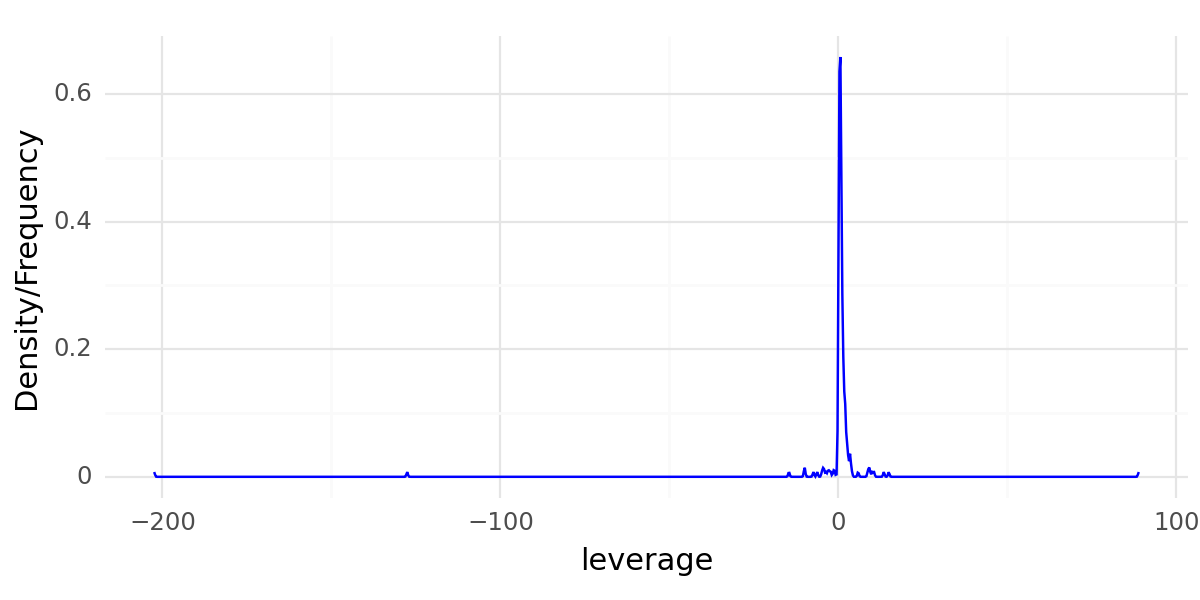

<Figure Size: (600 x 300)>

In [41]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='leverage', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [42]:
adjusted_dataset[(adjusted_dataset['leverage']<-15) | ((adjusted_dataset['leverage']>15))]

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
MTCH,1.116780,-2.169912,-202.430223,0.144533,4507.886,14.0,False
OGN,0.045327,-2.458280,-127.585714,0.084840,12058.000,17.0,False
ORCL,1.046668,-1.756670,88.844362,0.063274,134384.000,17.0,False


In [43]:
adjusted_dataset = adjusted_dataset[(adjusted_dataset['leverage']>-15) & ((adjusted_dataset['leverage']<15))]

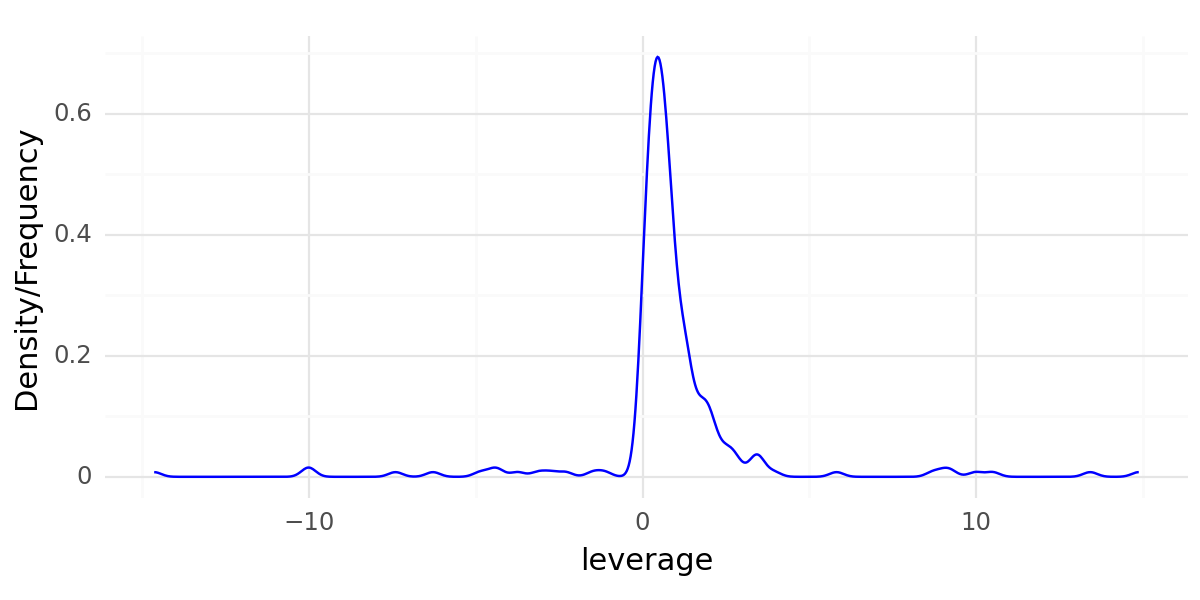

<Figure Size: (600 x 300)>

In [44]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='leverage', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

The board size variable looks good with the exception of some really small boards (<8 members).  Since these are very few, we decide to accept these cases. 

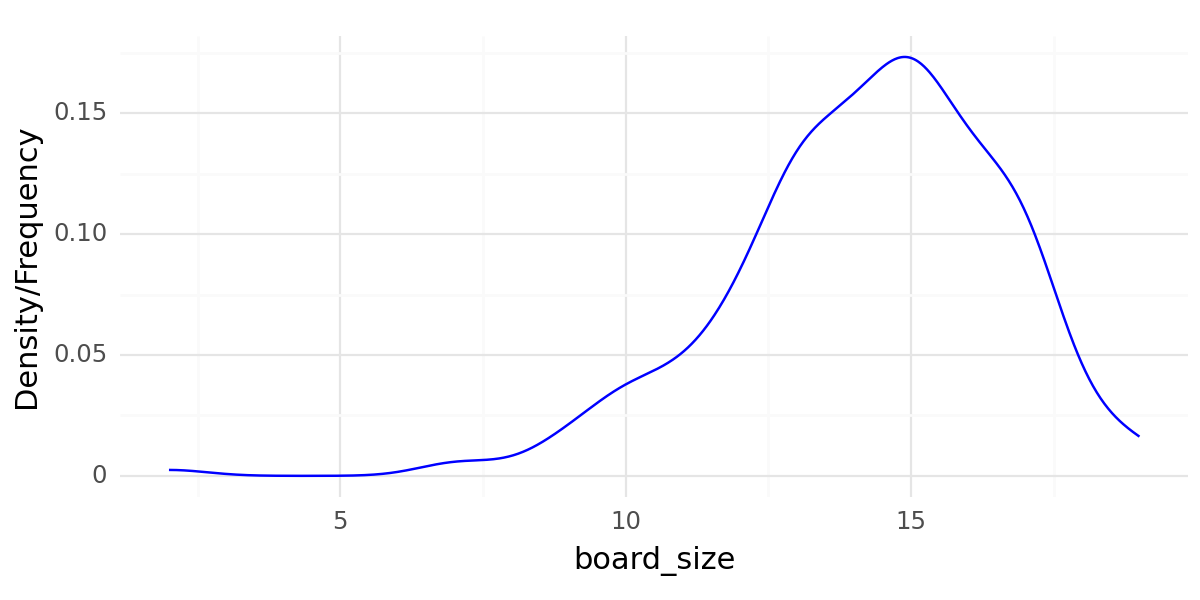

<Figure Size: (600 x 300)>

In [45]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='board_size', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [46]:
adjusted_dataset[(adjusted_dataset['board_size']<8)]

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
HCP,0.948820,-0.963257,0.011569,-0.112691,1691.947,7.0,True
KVUE,0.578294,-3.656014,0.751672,0.059747,27851.000,2.0,False
PHIN,-0.580093,-3.478387,0.457870,0.025241,4041.000,7.0,False


ROA looks relatively normal. 

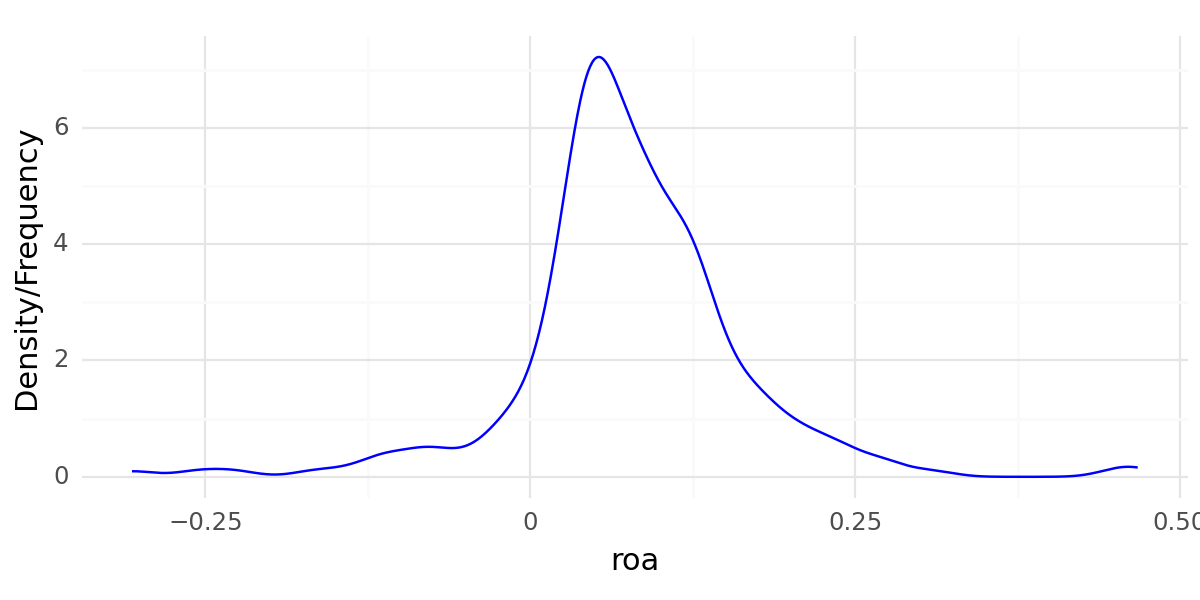

<Figure Size: (600 x 300)>

In [47]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='roa', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Total assets also exhibits huge outliers, and we log adjust. 

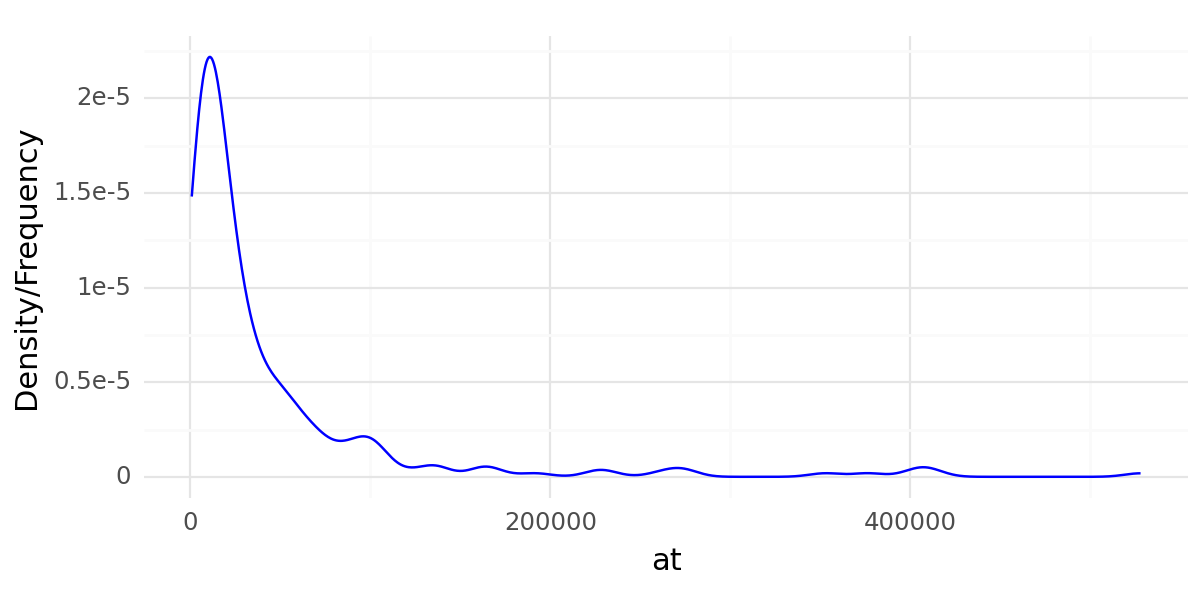

<Figure Size: (600 x 300)>

In [48]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='at', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [49]:
# we then log adjust to make the distribution more normal
adjusted_dataset = (adjusted_dataset
 .assign(
     at = lambda x:  np.log(x['at'])
 )
)

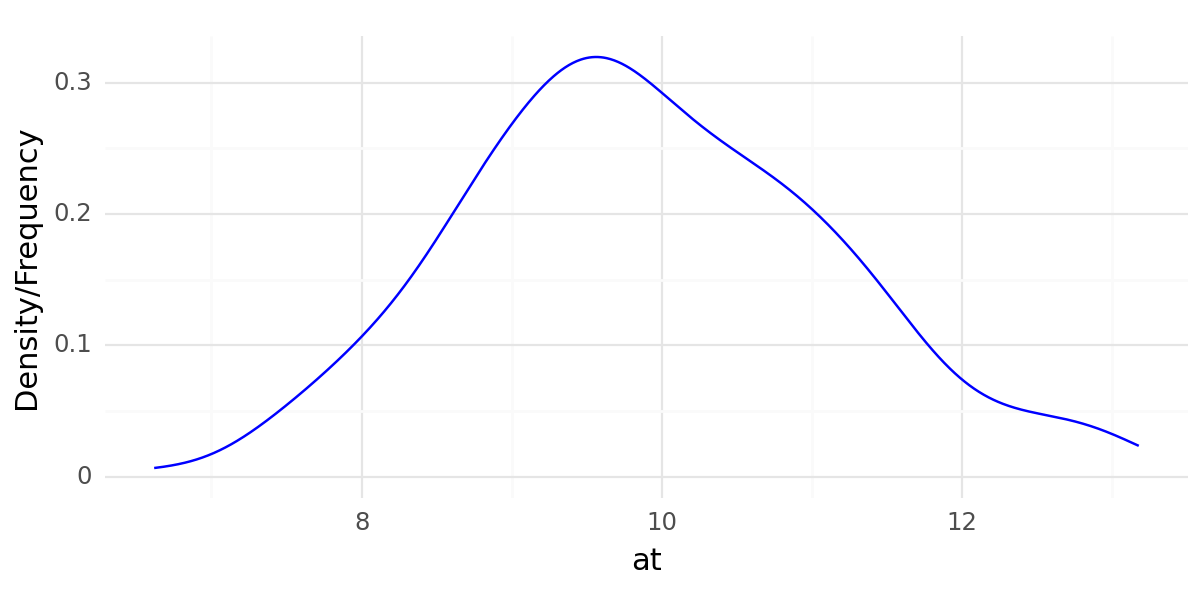

<Figure Size: (600 x 300)>

In [50]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='at', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Lastly, we check the balance of our CEO Duality variable.  We clearly have unequal group sizes, which we need to mention in the interpretation of our research, but we can't do much about given the archival (non-experimental) nature of this research. 

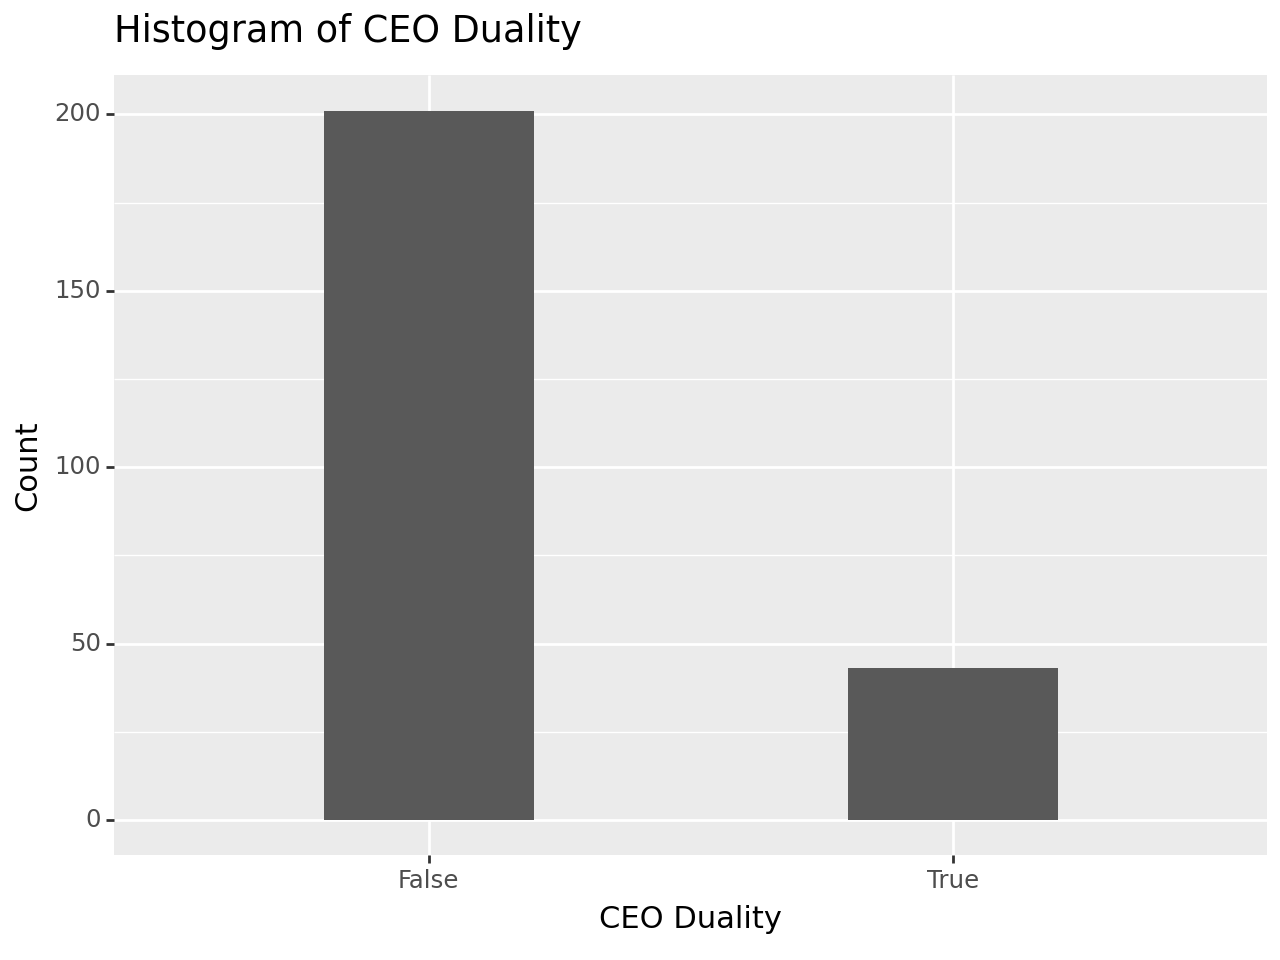

<Figure Size: (640 x 480)>

In [51]:
( ggplot(adjusted_dataset, aes(x='ceo_duality'))  # Specify the DataFrame and variable
    + geom_histogram(stat="count", width=0.4)  # Histogram to count True/False values
    + labs(x='CEO Duality', y='Count', title='Histogram of CEO Duality')
)

In [52]:
adjusted_dataset

,tobins_q,rd_intensity,leverage,roa,at,board_size,ceo_duality
tic,,,,,,,
A,1.123291,-2.653652,0.495979,0.115210,9.283870,15.0,False
AA,-0.561908,-5.600414,0.470948,-0.045991,9.557823,10.0,False
AAPL,2.067168,-2.550419,1.994175,0.275098,12.773041,13.0,False
ABBV,0.907871,-1.860334,5.819112,0.036100,11.810887,17.0,True
ABMD,2.199565,-1.306410,0.006324,0.081574,7.422609,12.0,False
...,...,...,...,...,...,...,...
XRAY,0.271946,-3.070325,0.698148,-0.017910,8.905173,16.0,False
XYL,0.633048,-3.457621,0.268149,0.037798,9.687320,14.0,False
ZBH,0.366618,-2.780055,0.480365,0.047635,9.975664,10.0,False


## Data Saving/Loading


In [ ]:
# Save data frames
datastore_ = pd.HDFStore('week2.h5')
datastore_['combined_dataset'] = combined_dataset
datastore_['adjusted_dataset'] = adjusted_dataset
datastore_.close()

In [ ]:
# Load data frames
datastore_ = pd.HDFStore('week2.h5')
combined_dataset = datastore_['combined_dataset'] 
adjusted_dataset = datastore_['adjusted_dataset'] 
datastore_.close()  

## Cross-Sectional Linear Regression

Now we are ready to run our regression.  

In [54]:
df_ = adjusted_dataset
df_numeric = combined_dataset.drop(columns = ["ceo_duality"])

### Fitting the Regression Model

To define our regression, we use the statsmodels formula API, which lists the dependent variable, followed by tilde (~) an then all the independent variables.  Interactions (our governance moderators) are entered using the colon (:). 

In [85]:
fit_ = smf.ols('tobins_q ~ roa + leverage + \
                rd_intensity + board_size +  ceo_duality + \
                board_size:rd_intensity + ceo_duality:rd_intensity', 
               data=df_).fit()

In [86]:
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tobins_q   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     32.78
Date:                Sat, 25 May 2024   Prob (F-statistic):           1.28e-31
Time:                        10:44:52   Log-Likelihood:                -182.58
No. Observations:                 244   AIC:                             381.2
Df Residuals:                     236   BIC:                             409.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.5482      0.488      5.218      0.000       1.586       3.510
ceo_duality[T.True]                 -0.0342      0.205     -0.166      0.868      -0.439       0.370
roa                                  4.6112      0.385     11.979      0.000       3.853       5.370
leverage                             0.0087      0.013      0.664      0.507      -0.017       0.034
rd_intensity                         0.5760      0.143      4.025      0.000       0.294       0.858
ceo_duality[T.True]:rd_intensity    -0.0036      0.061     -0.060      0.952      -0.123       0.116
board_size                          -0.1014      0.035     -2.927      0.004      -0.170      -0.033
board_size:rd_intensity             -0.0261      0.010     -2.641      0.009      -0.046      -0.007
==============================================================================
Omnibus:                        0.416   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.812   Jarque-Bera (JB):                0.554
Skew:                           0.030   Prob(JB):                        0.758
Kurtosis:                       2.775   Cond. No.                         813.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Removing leverage simplifies our regression, with similar results. 

In [79]:
fit_2 = smf.ols('tobins_q ~ roa + \
                 rd_intensity + board_size + ceo_duality + \
                 board_size:rd_intensity + ceo_duality:rd_intensity', 
                data=df_).fit()

In [80]:
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tobins_q   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     38.26
Date:                Sat, 25 May 2024   Prob (F-statistic):           2.44e-32
Time:                        10:42:27   Log-Likelihood:                -182.81
No. Observations:                 244   AIC:                             379.6
Df Residuals:                     237   BIC:                             404.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.5205      0.486      5.186      0.000       1.563       3.478
ceo_duality[T.True]                 -0.0324      0.205     -0.158      0.874      -0.437       0.372
roa                                  4.5819      0.382     11.996      0.000       3.829       5.334
rd_intensity                         0.5632      0.142      3.976      0.000       0.284       0.842
ceo_duality[T.True]:rd_intensity    -0.0051      0.061     -0.084      0.933      -0.124       0.114
board_size                          -0.0989      0.034     -2.876      0.004      -0.167      -0.031
board_size:rd_intensity             -0.0252      0.010     -2.579      0.011      -0.045      -0.006
==============================================================================
Omnibus:                        0.354   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.497
Skew:                           0.037   Prob(JB):                        0.780
Kurtosis:                       2.792   Cond. No.                         809.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Assessing Linear Regression Assumptions

Linear regression analysis is a powerful statistical method, but its reliability critically depends on several key assumptions about the data it models. Here are the primary assumptions that need to be met for the results of a linear regression to be considered valid:

1. Linearity: The relationship between the dependent and independent variables should be linear. This can be assessed visually using scatter plots of the variables or statistically through tests like the Harvey-Collier test.

2. Independence of Errors: The residuals (errors) of the model should not be correlated with each other. This assumption means that the value of the error term for one observation does not depend on the value of the error term for another observation. The Durbin-Watson test is commonly used to check for autocorrelation in the residuals.

3. Homoscedasticity: This assumption states that the variance of the error terms is constant across all levels of the independent variables. If the variance changes (a problem known as heteroscedasticity), it can lead to inefficient estimates and affect the inference of the regression model. Scatter plots of residuals versus predicted values and statistical tests like Breusch-Pagan can be used to assess homoscedasticity.

4. Normality of Residuals: For inference purposes, such as constructing confidence intervals and conducting hypothesis tests, the residuals should ideally follow a normal distribution. This is especially important in small sample sizes. Normality can be assessed using Q-Q plots,  or tests like the Omni-test or Jarque-Bera test.

5. No Perfect Multicollinearity: The model should not include multiple independent variables that are perfectly linearly related. This can lead to issues in estimating the coefficients of the model, as it becomes difficult to discern the effect of each individual independent variable. Checking the correlation matrix and variance inflation factors (VIF) can help detect multicollinearity.

6. No extreme values or outliers: Outliers can have a disproportionately large effect on the fit of a linear regression model and can lead to misleading results. Diagnostics for detecting outliers include analyzing studentized residuals, leverage, and influence plots.

7. Additivity: This assumption implies that the effect of changes in an independent variable XX on the dependent variable YY is consistent regardless of the values of other variables in the model. This can be checked by looking at interaction terms in the data.

#### 1. Linearity

Linear regression assumes that the relationship between the independent and dependent variable is linear in nature.  We will check this assumptions in two ways:  (1) pair plots allow us to determine if a strictly linear model is able to efficiently explain the data based on the dispersion of the data points and (2) a formal statistical test that the linear specification is correct with the Omnibus and Jarque-Bera tests.

Both of these tests are included in the standard regression output table. 
- The Omnibus test is a test of the skewness and kurtosis of the residuals to assess their deviation from a normal distribution. A significant result Prob(Omnibus) (typically p < 0.05) indicates that the residuals are not normally distributed, which could invalidate some of the assumptions underlying OLS regression.
- The Jarque-Bera test is a more specific test that measures the goodness of fit of the residuals of a regression model against a normal distribution. It combines the skewness and kurtosis of the residuals into a single statistic. Like the Omnibus test, a significant Jarque-Bera test (Prob(JB in the output)) (p < 0.05) indicates a departure from normality.

#### 2. Independence of Errors

The Durbin-Watson test is commonly used in regression analysis to detect the presence of autocorrelation in the residuals of a regression model. Understanding the output of the Durbin-Watson test can help you determine if the assumptions of independence in your regression model are being violated, which can affect the validity of your results.

The null hypothesis of the Durbin-Watson test is that there is no serial correlation in the residuals.   This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.  While it is possible to calculate the p-value for the DW statistic, this involves a complex process because the distribution depends on the design matrix of the model. 

In [65]:
sms.durbin_watson(fit_2.resid)

1.891130821911883

#### 3. Homoskedasticity

We use Breusch-Pagan to test for heteroskedasticity.   The  null hypothesis of this test is that the error variances are all equal. 

In [66]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(fit_2.resid, fit_2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 12.952751639137318),
 ('p-value', 0.04379242043573158),
 ('f-value', 2.214411525675587),
 ('f p-value', 0.042472624771297304)]

A Zpred/Zresid plot is a useful diagnostic tool that plots standardized predicted values (Zpred) against standardized residuals (Zresid). This type of plot can help detect non-linear patterns, heteroscedasticity, and influential observations in the residuals of a regression model. 

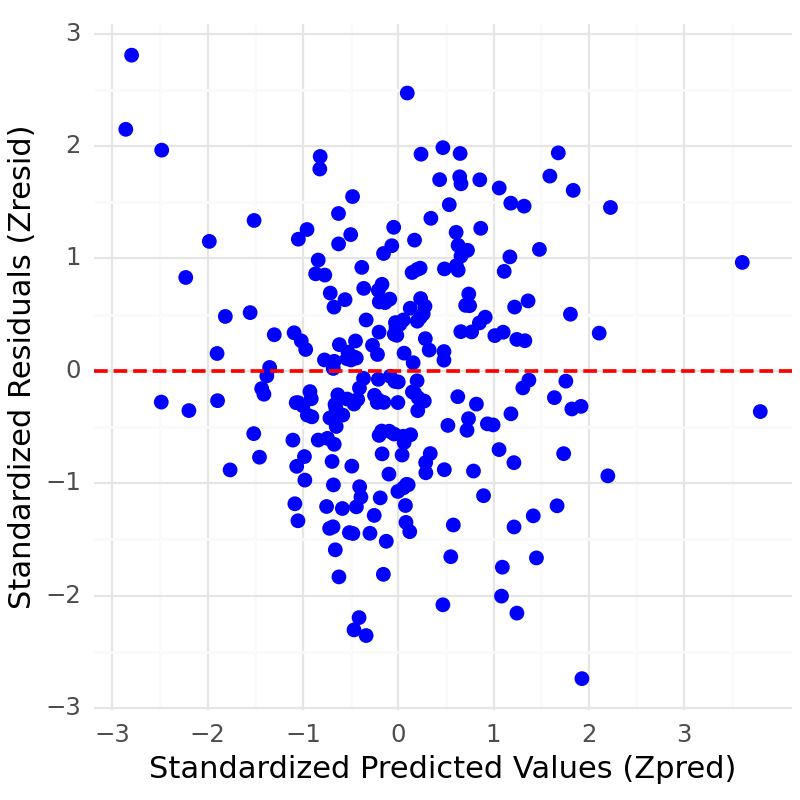

<Figure Size: (400 x 400)>

In [67]:
# Get predicted values and residuals
predicted_values = fit_2.predict(df_)
residuals = fit_2.resid

# Create a plot dataframe with normalized values
plot_data = pd.DataFrame({
    'Zpred': (predicted_values - np.mean(predicted_values)) / np.std(predicted_values),
    'Zresid': (residuals - np.mean(residuals)) / np.std(residuals)
})

# Create the plot
(
    ggplot(plot_data, aes(x='Zpred', y='Zresid'))  # Define the data and aesthetic mapping
    + geom_point(color='blue', size=2)  # Scatterplot points
    + geom_hline(yintercept=0, color='red', linetype='dashed', size=0.75)  # Horizontal line at zero
    + labs(x='Standardized Predicted Values (Zpred)', y='Standardized Residuals (Zresid)')  # Labels
    + theme_minimal()  # Minimal theme for a clean look
    + scale_x_continuous(breaks=np.arange(-3, 4, 1))  # Customize the x-axis breaks
    + scale_y_continuous(breaks=np.arange(-3, 4, 1))  # Customize the y-axis breaks
    + theme(figure_size=(4, 4)) 
)

#### 4. Normality of Residuals

The Quantile-Quantile plot (QQ-Plot), is a graphical tool used to assess whether a dataset follows a specific theoretical distribution, such as the normal distribution. It compares the quantiles of the data to the quantiles of the theoretical distribution, providing a visual means to evaluate the distributional assumptions of a dataset.

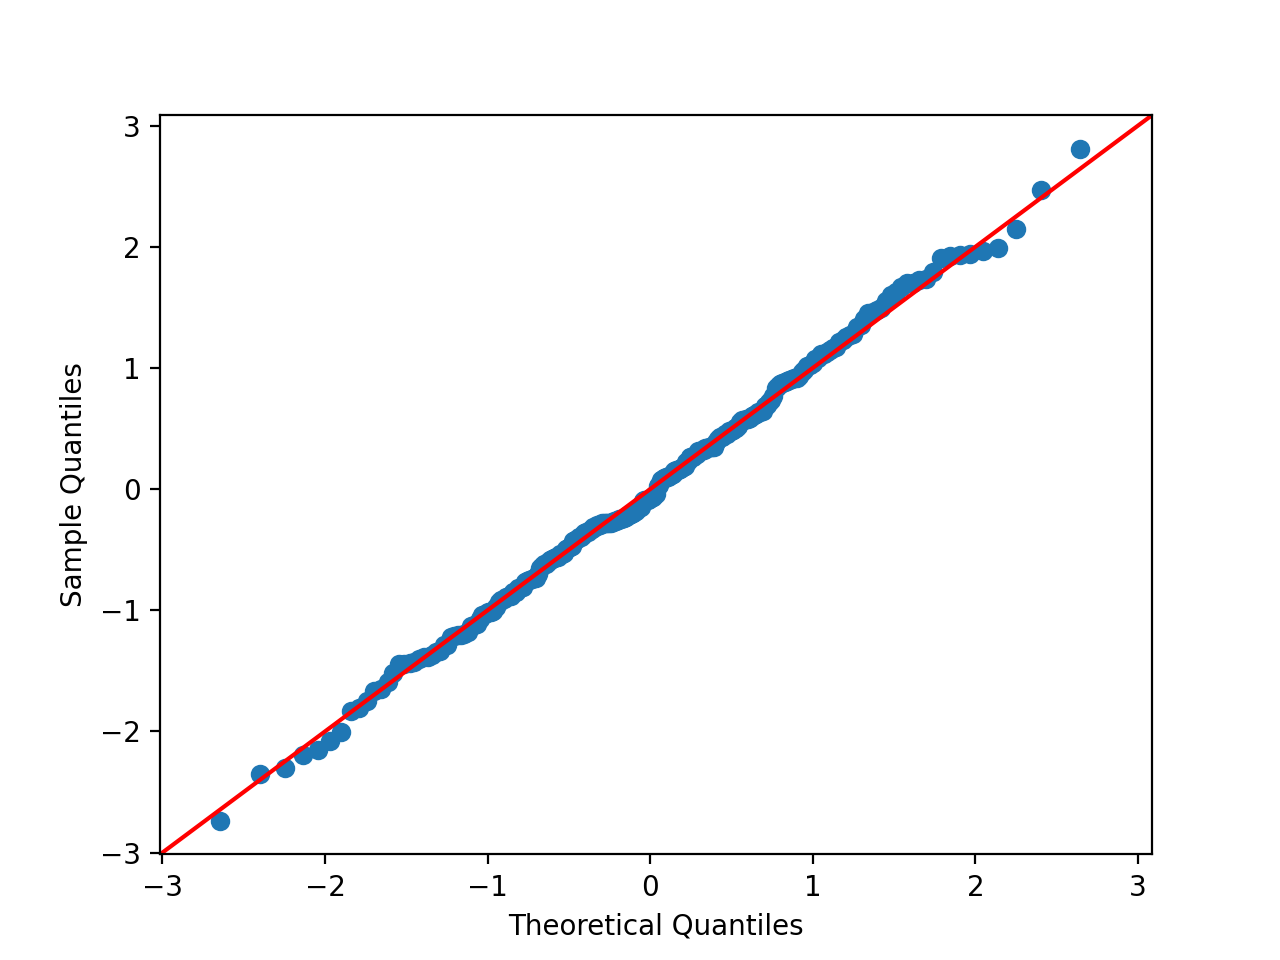

In [68]:
sm.qqplot(fit_2.resid,  fit=True, line='45');

We use the Jacque-Bera test to determine if the residuals are normally distributed.  Null hypothesis for the test is that the  (residuals in this case) is normally distributed (do we reject the Null?).

In [69]:
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(fit_2.resid)
lzip(name, test)

[('Jarque-Bera', 0.4974197220748135),
 ('Chi^2 two-tail prob.', 0.7798061927253723),
 ('Skew', 0.03702616018493715),
 ('Kurtosis', 2.791570674117141)]

Omnibus test in the context of regression analysis performed using the statsmodels library is a test of the skewness and kurtosis of the residuals of your model. Essentially, it tests the hypothesis that the residuals are normally distributed. 
It provides a test statistic that measures the combined effect of skewness and kurtosis of the residuals. A higher value indicates a deviation from normality.  The p-value is the critical component for interpreting the test because it tells you the probability of observing the calculated statistic (or one more extreme) under the null hypothesis that the residuals are normally distributed.

In [70]:
name = ["Chi^2", "Two-tail probability"]
test = sms.omni_normtest(fit_2.resid)
lzip(name, test)

[('Chi^2', 0.35432328896894194), ('Two-tail probability', 0.8376443729861833)]

#### 5. No Perfect Multicollinearity (Independence of Parameters)

Multicollinearity is indicated when the variance inflation factor is higher than 5.

In [71]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_numeric.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) 
                          for i in range(len(df_numeric.columns))] 

In [72]:
vif_data

,feature,VIF
0,tobins_q,4.023126
1,rd_intensity,1.524321
2,leverage,1.002438
3,roa,3.095216
4,at,1.141521
5,board_size,2.222999


Another indication of this is the condition number.  We don't want this to be higher than say 10-30, the higher the condition number, the more correlation exists among the parameters.

In [73]:
fit_2.condition_number

809.0299834421777

#### 6. No Extreme Values or Outliers

*Cook's distance* is a measure used in regression analysis to identify influential points. It measures the effect of deleting a given observation. Points with a large Cook's distance are considered to potentially be outliers or influential points that could unduly affect the model's predictions.

In [74]:
# Calculate influence measures
influence = fit_2.get_influence()

# Obtain Cook's distance for each observation
cooks_d, pvals = influence.cooks_distance

# Create DataFrame for plotting
data = pd.DataFrame({
    'Observation Index': np.arange(len(cooks_d)),
    'Cook\'s Distance': cooks_d
})

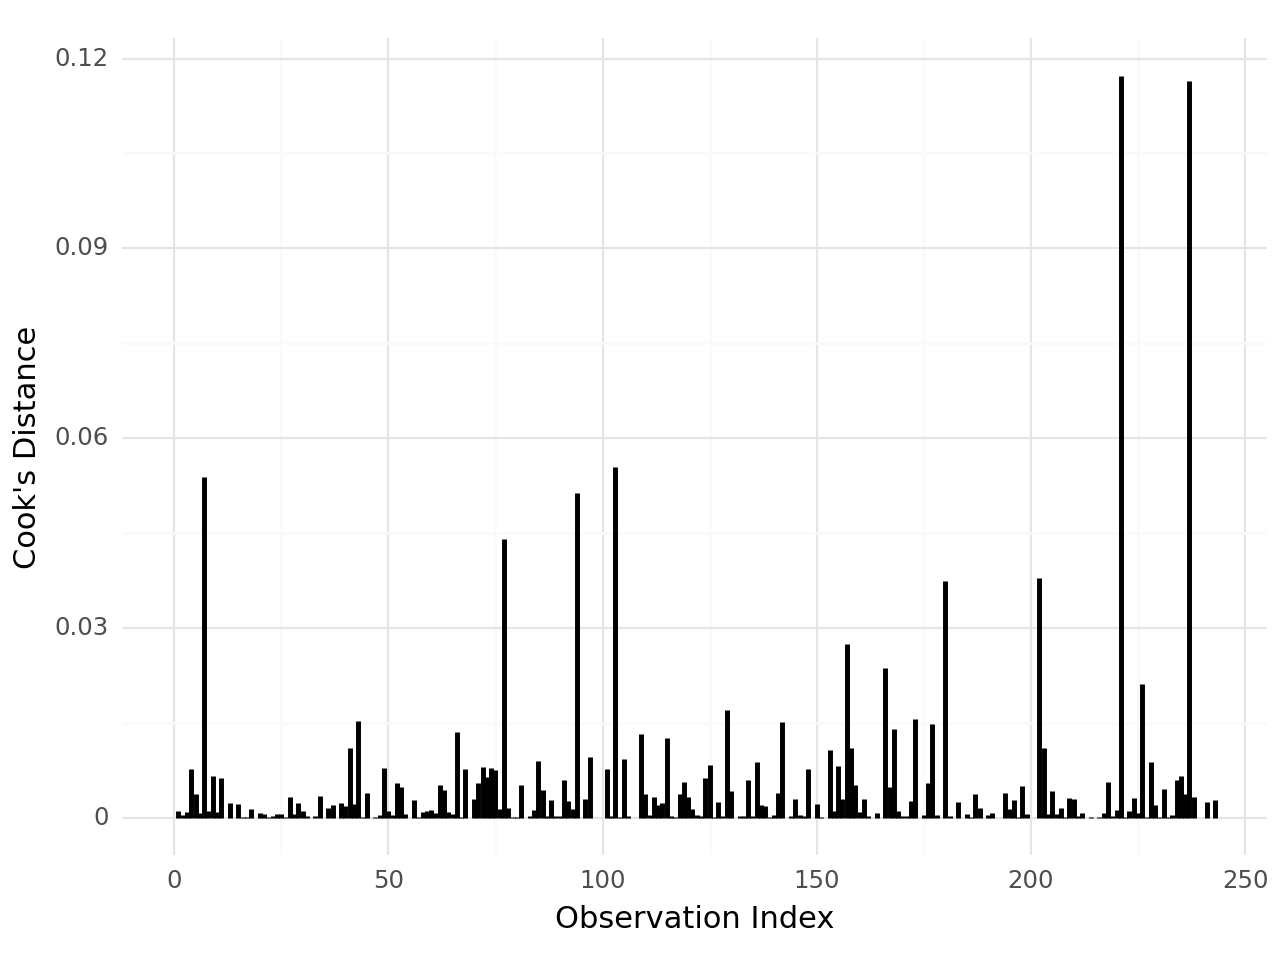

<Figure Size: (640 x 480)>

In [75]:
(
    ggplot(data, aes(x='Observation Index', y='Cook\'s Distance'))
    + geom_segment(aes(x='Observation Index', xend='Observation Index', y=0, yend='Cook\'s Distance'), size=1)  # Create vertical lines (like stems)
    #+ geom_point(shape='o', color='blue', size=2)  # Add points to the tips of stems
    + labs( x='Observation Index', y="Cook's Distance")
    + theme_minimal()  # Apply a minimalistic theme
)

Depending on your specific research question and the customs of your domain, you might want to include other tests in your approach. A plethora of additional tests is available directly as part of the statsmodels packages, and you can find more information in the package's docs at:  https://www.statsmodels.org/v0.13.5/stats.html.


#### 7. Additivity and Functional Form

Testing for the additivity assumption in a regression model involves checking if the effects of individual predictors on the response variable are consistent regardless of the values of other predictors. This assumption implies that there are no significant interactions between predictors that affect the response variable. If interactions do exist and are significant, the additivity assumption may be violated, suggesting that the model might need to include interaction terms to adequately capture the relationships among variables.

Testing for additivity by introducing interaction terms and assessing their significance is a robust approach to ensuring your model accurately represents the underlying data relationships. If you find significant interactions, it implies that the additive model may be insufficient, and you need to account for these interactions in your analysis. This can involve refining the model further or using alternative modeling approaches if interactions are complex or non-linear.

In interpreting the output, take a look at the signficance of the interaction term. The statistical significance of the interaction terms can be assessed by looking at the p-values in the regression output. Significant p-values for interaction terms indicate that the effect of one predictor variable on the dependent variable depends on the value of another predictor.   If interaction terms are significant, it suggests that additivity does not hold, and these terms should be included in the model to properly model the relationships.

In [76]:
# Create a model with interaction terms (the ":" operator create the interaction term)
formula = 'tobins_q ~ roa + \
           rd_intensity + board_size +  ceo_duality + \
           board_size:rd_intensity + ceo_duality:rd_intensity + \
           roa:board_size + roa:ceo_duality'  

model = smf.ols(formula, data=df_)
fit_interact = model.fit()
fit_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tobins_q   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     28.60
Date:                Sat, 25 May 2024   Prob (F-statistic):           7.05e-31
Time:                        10:41:35   Log-Likelihood:                -182.50
No. Observations:                 244   AIC:                             383.0
Df Residuals:                     235   BIC:                             414.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.5638      0.491      5.219      0.000       1.596       3.531
ceo_duality[T.True]                 -0.0968      0.224     -0.433      0.666      -0.537       0.344
roa                                  3.9050      2.218      1.760      0.080      -0.466       8.276
roa:ceo_duality[T.True]              0.8892      1.247      0.713      0.477      -1.568       3.346
rd_intensity                         0.5635      0.145      3.896      0.000       0.279       0.848
ceo_duality[T.True]:rd_intensity    -0.0043      0.061     -0.071      0.944      -0.124       0.115
board_size                          -0.1017      0.035     -2.924      0.004      -0.170      -0.033
board_size:rd_intensity             -0.0253      0.010     -2.533      0.012      -0.045      -0.006
roa:board_size                       0.0423      0.158      0.268      0.789      -0.268       0.353
==============================================================================
Omnibus:                        0.342   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.486
Skew:                           0.023   Prob(JB):                        0.784
Kurtosis:                       2.786   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Describing Results

The model explains a substantial portion of the variability in Tobin's Q with an R-squared of 0.512, suggesting that approximately 51.2% of the variation in firm value (as measured by Tobin's Q) can be accounted for by the independent variables included. The Adjusted R-squared of 0.500 indicates a robust fit, adjusting for the number of predictors.

Hypotheses Evaluation:
- Hypothesis 1 (H1) posited that R&D intensity positively affects firm value. This is supported by the significant positive coefficient for rd_intensity (β = 0.557, p < 0.001), indicating that increases in R&D intensity are associated with increases in firm value.
- Hypothesis 2 (H2) suggested that CEO duality weakens the relationship between R&D intensity and firm value. The interaction term ceo_duality[T.True]:rd_intensity was not statistically significant (β = 0.0177, p = 0.764), providing no evidence to support H2. This suggests that CEO duality does not significantly alter the positive impact of R&D intensity on firm value.
- Hypothesis 3 (H3) proposed that a larger board size strengthens the positive relationship between R&D intensity and firm value. The coefficient for the interaction board_size:rd_intensity is significant but negative (β = -0.0254, p = 0.008), contrary to the hypothesis. This indicates that as board size increases, the positive impact of R&D intensity on firm value is actually diminished, suggesting potentially bureaucratic inefficiencies or dilution of strategic focus with larger boards.

Additional Findings:
- The variable ceo_duality itself, indicating whether the CEO is also the chairman, shows no significant effect on firm value (β = 0.0533, p = 0.792).
- The roa (return on assets) has a strong positive influence on Tobin's Q (β = 4.8913, p < 0.001), underscoring the importance of operational efficiency in enhancing firm value.
-  The negative coefficient for board_size (β = -0.1047, p = 0.002) suggests that larger board sizes may detract from firm value, potentially due to increased complexity or slower decision-making processes.

Model Diagnostics:
- The model exhibits good properties with a Durbin-Watson statistic of 1.895, indicating no serious autocorrelation issues. Normality tests (Omnibus, Jarque-Bera) show no significant deviations from normality, supporting the validity of statistical inferences made from the model.

Overall, the regression analysis provides substantial support for the positive impact of R&D intensity on firm value while refuting the proposed moderating effects of CEO duality. It also raises concerns about the efficacy of larger board sizes in the context of leveraging R&D investments. These insights are crucial for corporate governance structures aiming to maximize firm valuation.

### Visualizing Results

#### Regression Tables

In [155]:
from IPython.display import HTML, display

Statsmodels provides a summary method for regression results that produces a comprehensive statistical summary of a single model. The output includes coefficients, standard errors, p-values, and other diagnostics. You can display this in HTML format in a Jupyter Notebook or copy/paste it to a Word document.  Latex export features are also available. 

In [156]:
display(HTML(fit_2.summary().as_html()))

To create a journal-quality regression tables for multiple regression models, you can use the stargazer library for Python. This library allows you to produce nicely formatted LaTeX, HTML, or text regression tables. You can find more information about the options of the functions on the packages' GitHub site at:  https://github.com/StatsReporting/stargazer

Here is an example:

In [157]:
from stargazer.stargazer import Stargazer

In [162]:
# Create a Stargazer object
stargazer = Stargazer([fit_2, fit_3, fit_interact])

# Set custom configurations if needed
stargazer.title('Regression Results')
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])
stargazer.add_custom_notes(['Sample of all SP500 firms with R\&D intensity.'])

# Render HTML (useful for Jupyter Notebooks) or get LaTeX code
html_output = stargazer.render_html()
#print(html_output) 
display(HTML(html_output))


#### Regression Graphs

Creating a grid of graphs for each variable in a dataset is useful to visualize the slopes of the regression. plotnine in Python has a useful features using facets to facilitate this. Faceting is a powerful technique for creating multiple plots based on a dataset's categorical variables or for plotting relationships separately for each variable.

In [163]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme_minimal

In [164]:
fit_2.params

Intercept                           2.534201
ceo_duality[T.True]                 0.053312
roa                                 4.891261
rd_intensity                        0.556977
ceo_duality[T.True]:rd_intensity    0.017716
board_size                         -0.104673
board_size:rd_intensity            -0.025431
dtype: float64

To facilitate easier plotting with plotnine, reshape the data so that each variable appears in a single column with its corresponding values.  The id_vars array contains the dependent variable name. 

In [182]:
df_melted = ( df_
             .get(['tobins_q','roa','rd_intensity','board_size'])
             .melt(id_vars=['tobins_q'], var_name='variable', value_name='value')
            )


In [183]:
df_melted

,tobins_q,variable,value
0,1.123291,roa,0.115210
1,-0.561908,roa,-0.045991
2,2.067168,roa,0.275098
3,0.907871,roa,0.036100
4,2.199565,roa,0.081574
...,...,...,...
724,0.271946,board_size,16.000000
725,0.633048,board_size,14.000000
726,0.366618,board_size,10.000000
727,0.812081,board_size,13.000000


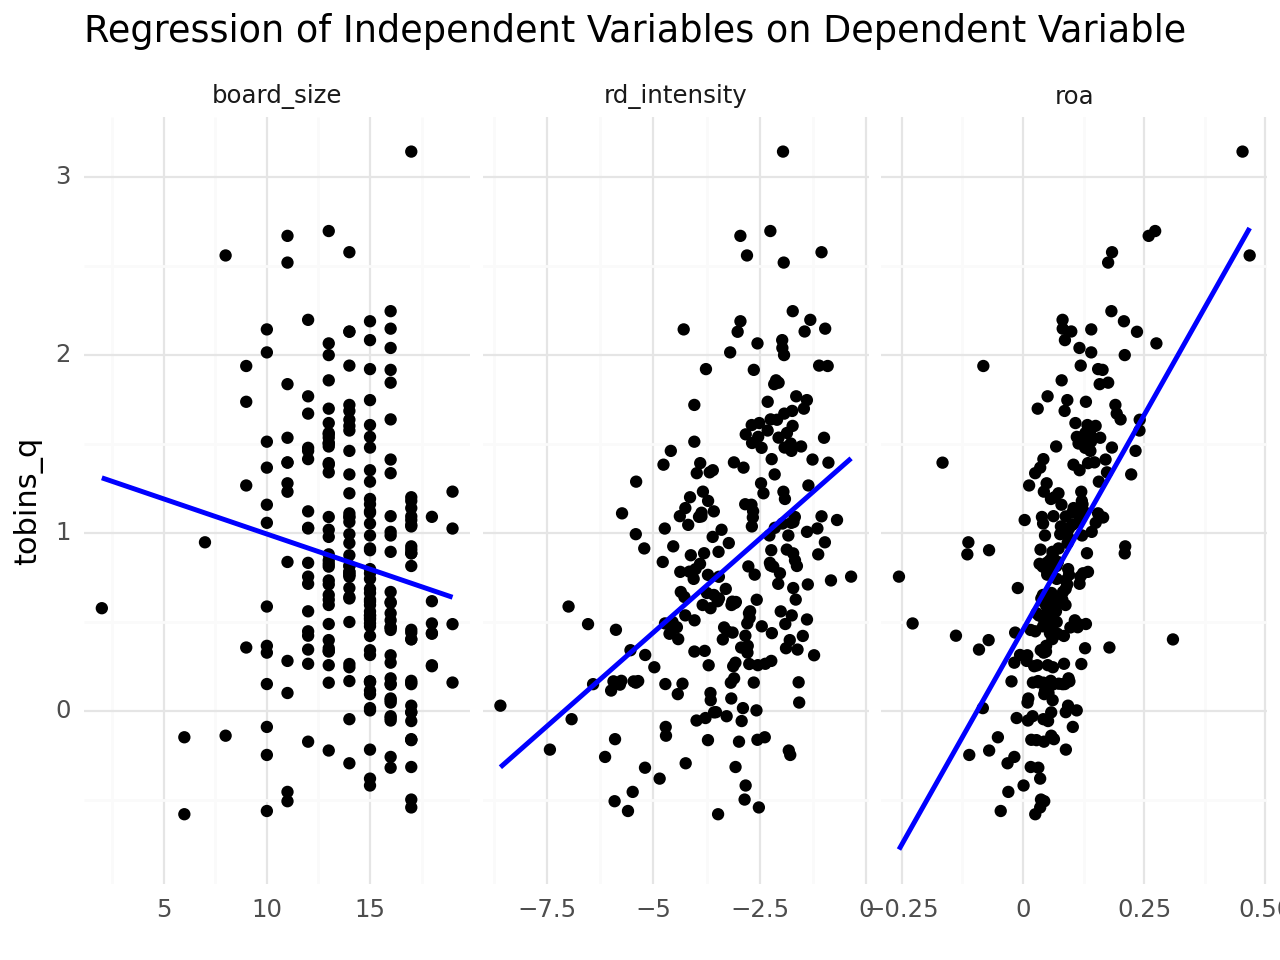

<Figure Size: (640 x 480)>

In [188]:
(ggplot(df_melted, aes(x='value', y='tobins_q')) 
     + geom_point()    # Add scatter plot points
     + geom_smooth(method='lm', color='blue', se=False)   # Add linear regression line, without confidence interval
     + facet_wrap('~variable', scales='free_x')   # Create a separate plot for each variable
     + labs(title='Regression of Independent Variables on Dependent Variable', x='', y='tobins_q') 
     + theme_minimal()
)

#### Interaction Diagram

For interactions, it is often useful to show two different lines at different values of of the moderator.  We simulate this here, keeping roa and ceo_duality constant. 

In [224]:
# Assuming your original DataFrame is called df and contains columns 'board_size' and 'rd_intensity'
mean_board_size = df_['board_size'].mean()
std_board_size = df_['board_size'].std()
roa_mean = df_['roa'].mean()
ceo_duality = False

# Creating a new DataFrame for plotting
plot_data = pd.DataFrame({
    'rd_intensity': np.linspace(df_['rd_intensity'].min(), df_['rd_intensity'].max(), 100)
})
plot_data['board_size_mean_plus'] = mean_board_size + std_board_size
plot_data['board_size_mean_minus'] = mean_board_size - std_board_size

# Generate predictions for +1 SD
plot_data['predicted_tobinq_plus'] = fit_2.predict(pd.DataFrame({
    'rd_intensity': plot_data['rd_intensity'],
    'roa':roa_mean,
    'ceo_duality':ceo_duality,
    'board_size': plot_data['board_size_mean_plus']
}))

# Generate predictions for -1 SD
plot_data['predicted_tobinq_minus'] = fit_2.predict(pd.DataFrame({
    'rd_intensity': plot_data['rd_intensity'],
    'roa':roa_mean,
    'ceo_duality':ceo_duality,
    'board_size': plot_data['board_size_mean_minus']
}))

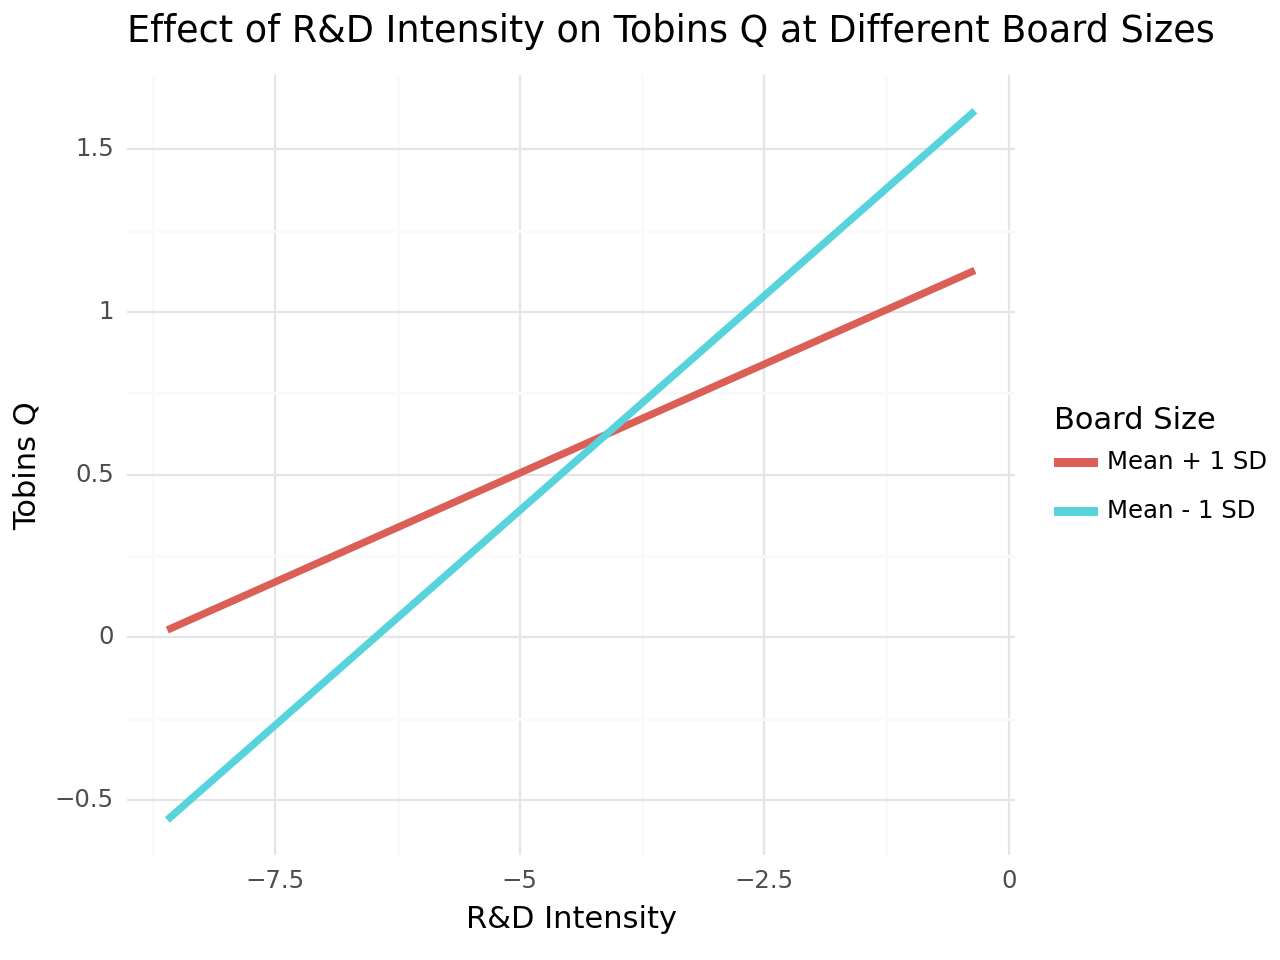

<Figure Size: (640 x 480)>

In [236]:
(
    ggplot(plot_data)
    + aes(x='rd_intensity')
    + geom_line(aes(y='predicted_tobinq_plus', color='"Mean + 1 SD"'), size=1.5)  # Line for Mean + 1 SD
    + geom_line(aes(y='predicted_tobinq_minus', color='"Mean - 1 SD"'), size=1.5)  # Line for Mean - 1 SD
    + labs(x='R&D Intensity', y='Tobins Q', title='Effect of R&D Intensity on Tobins Q at Different Board Sizes',
           color='Board Size')
    + theme_minimal()
)

# Assignment

Time for your second research project in Python. 

Replicate the steps of the example study above, but pick a different moderator variable of your choice.  How does your moderator impact the relationship between R\&D investment and firm value?   If you feel more adventurous, please be free to make more changes to the model, such as changing the outcome variable or the control variables. 

Follow the steps outlined in this notebook, namely:

1. Identify a data source for this task (hint: search on WRDS).
2. Download the relevant data.
3. Create and review the descriptive statistics of all variables you want to use.
4. Adjust your variables as required. 
5. Create regressions to identify group differences.
6. Assess the assumptions of each regression to understand the believability of the results.
7. Write-up the result and provide the relevant graphs. 

Create a report with a minimum of one graph and one table for your results.  In your report, briefly develop an hypothesis based on the literature and reason how your findings correspond to your expectations. 